In [16]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("🚀 Setting up environment...")

# Set your paths here
FTIR_CSV_PATH = "/Users/ahzs645/Github/aethmodular-clean/Four_Sites_FTIR_data.v2.csv"
# Add path to your existing processed Ethiopia data if you have it
ETHIOPIA_PKL_PATH = "pkl_data_cleaned_ethiopia.pkl"  # Adjust this path

print("✅ Setup complete!")

🚀 Setting up environment...
✅ Setup complete!


In [17]:
# FTIR CSV Loader and Speciation Data Integration (embedded in notebook for simplicity)
from typing import Optional

class FTIRCSVLoader:
    """Load and process FTIR data from CSV files"""
    
    def __init__(self, csv_path: str):
        self.csv_path = Path(csv_path)
        if not self.csv_path.exists():
            raise FileNotFoundError(f"FTIR CSV file not found: {self.csv_path}")
        
    def load_site_data(self, site_code: str, parameters=None) -> pd.DataFrame:
        """Load FTIR data for a specific site"""
        print(f"📊 Loading FTIR data for site {site_code}...")
        
        # Load the full CSV
        df = pd.read_csv(self.csv_path)
        
        # Filter by site
        site_data = df[df['Site'] == site_code].copy()
        
        if len(site_data) == 0:
            available_sites = df['Site'].unique()
            raise ValueError(f"No data found for site '{site_code}'. Available sites: {list(available_sites)}")
        
        # Convert sample date to datetime
        site_data['SampleDate'] = pd.to_datetime(site_data['SampleDate'])
        
        # Filter parameters if specified
        if parameters:
            site_data = site_data[site_data['Parameter'].isin(parameters)]
        
        # Pivot to get parameters as columns
        pivot_data = site_data.pivot_table(
            index='SampleDate',
            columns='Parameter',
            values='Concentration_ug_m3',
            aggfunc='mean'  # Average if multiple measurements per day
        ).reset_index()
        
        # Set datetime index
        pivot_data.set_index('SampleDate', inplace=True)
        pivot_data.index.name = 'datetime_local'
        
        print(f"✅ Loaded {len(pivot_data)} FTIR measurements")
        print(f"📅 Date range: {pivot_data.index.min()} to {pivot_data.index.max()}")
        print(f"🧪 Parameters: {list(pivot_data.columns)}")
        
        return pivot_data
    
    def get_available_sites(self):
        """Get list of available sites"""
        df = pd.read_csv(self.csv_path)
        return sorted(df['Site'].unique())
    
    def get_available_parameters(self, site_code=None):
        """Get list of available parameters"""
        df = pd.read_csv(self.csv_path)
        if site_code:
            df = df[df['Site'] == site_code]
        return sorted(df['Parameter'].unique())


def load_etad_speciation_data(csv_path: str) -> Optional[pd.DataFrame]:
    """Load ETAD speciation data with proper unit handling"""
    
    print("🧪 Loading speciation data...")
    
    try:
        # Load CSV (skip first 3 lines to get to header)
        df = pd.read_csv(csv_path, skiprows=3)
        print(f"   Raw data: {len(df)} rows, {len(df.columns)} columns")
        
        # Filter for ETAD
        df = df[df['Site_Code'] == 'ETAD'].copy()
        print(f"   ETAD data: {len(df)} rows")
        
        # Create datetime
        def create_timestamp(row):
            try:
                return pd.Timestamp(
                    year=int(row['Start_Year_local']),
                    month=int(row['Start_Month_local']),
                    day=int(row['Start_Day_local']),
                    hour=int(row['Start_hour_local'])
                )
            except:
                return pd.NaT
        
        df['Start_Date'] = df.apply(create_timestamp, axis=1)
        df = df[df['Start_Date'].notna()].copy()
        
        print(f"   ✅ Created datetime for {len(df)} rows")
        
        # Map parameter codes to clean names with units
        parameter_mapping = {
            28101: 'PM25_mass',          # μg/m³
            28202: 'BC_PM25',            # μg/m³  
            28401: 'Sulfate_Ion',        # μg/m³
            28402: 'Nitrate_Ion',        # μg/m³
            28403: 'Phosphate_Ion',      # μg/m³
            28404: 'Nitrite_Ion',        # μg/m³
            28801: 'Sodium_Ion',         # μg/m³
            28802: 'Ammonium_Ion',       # μg/m³
            28803: 'Potassium_Ion',      # μg/m³
            28804: 'Magnesium_Ion',      # ng/m³ (note different unit!)
            28805: 'Calcium_Ion',        # μg/m³
            28902: 'Aluminum',           # ng/m³
            28904: 'Titanium',           # ng/m³
            28905: 'Vanadium',           # ng/m³
            28906: 'Chromium',           # ng/m³
            28907: 'Manganese',          # ng/m³
            28908: 'Iron',               # ng/m³
            28909: 'Cobalt',             # ng/m³
            28910: 'Nickel',             # ng/m³
            28911: 'Copper',             # ng/m³
            28912: 'Zinc',               # ng/m³
            28913: 'Arsenic',            # ng/m³
            28914: 'Selenium',           # ng/m³
            28916: 'Cadmium',            # ng/m³
            28917: 'Antimony',           # ng/m³
            28919: 'Cerium',             # ng/m³
            28920: 'Lead',               # ng/m³
            28921: 'Rubidium',           # ng/m³
            28922: 'Strontium',          # ng/m³
            28923: 'Silicon',            # ng/m³
            28924: 'Sulfur',             # ng/m³
            28925: 'Chlorine',           # ng/m³
            28926: 'Tin'                 # ng/m³
        }
        
        # Unit conversion mapping (ng/m³ to μg/m³ for consistency)
        ng_to_ug_species = [
            'Magnesium_Ion', 'Aluminum', 'Titanium', 'Vanadium', 'Chromium', 
            'Manganese', 'Iron', 'Cobalt', 'Nickel', 'Copper', 'Zinc', 
            'Arsenic', 'Selenium', 'Cadmium', 'Antimony', 'Cerium', 'Lead',
            'Rubidium', 'Strontium', 'Silicon', 'Sulfur', 'Chlorine', 'Tin'
        ]
        
        # Map parameter codes
        df['Parameter_Name_Clean'] = df['Parameter_Code'].map(parameter_mapping)
        mapped_count = df['Parameter_Name_Clean'].notna().sum()
        print(f"   📊 Mapped {mapped_count} parameter measurements")
        
        # Keep only mapped parameters
        df_mapped = df[df['Parameter_Name_Clean'].notna()].copy()
        
        # Pivot to wide format
        speciation_wide = df_mapped.pivot_table(
            index=['Filter_ID', 'Start_Date'],
            columns='Parameter_Name_Clean',
            values='Value',
            aggfunc='first'
        ).reset_index()
        
        speciation_wide.columns.name = None
        
        # Convert ng/m³ to μg/m³ for consistency
        for species in ng_to_ug_species:
            if species in speciation_wide.columns:
                speciation_wide[species] = speciation_wide[species] / 1000  # ng/m³ → μg/m³
        
        print(f"   ✅ Created wide format: {len(speciation_wide)} unique samples")
        print(f"   📏 All species now in μg/m³ units")
        
        return speciation_wide
        
    except Exception as e:
        print(f"❌ Error loading speciation data: {e}")
        return None


def merge_etad_datasets(ftir_data: pd.DataFrame, spec_data: pd.DataFrame) -> Optional[pd.DataFrame]:
    """Merge FTIR and speciation datasets"""
    
    print("🔗 Merging datasets...")
    
    if ftir_data is None or spec_data is None:
        print("❌ Cannot merge - missing data")
        return None
    
    print(f"   FTIR samples: {len(ftir_data)}")
    print(f"   Speciation samples: {len(spec_data)}")
    
    # Try direct filter ID merge first
    merged = pd.merge(
        ftir_data,
        spec_data,
        left_on='filter_id',
        right_on='Filter_ID',
        how='inner'
    )
    
    print(f"   Direct filter ID merge: {len(merged)} matches")
    
    # If no direct matches, try date-based merge
    if len(merged) == 0:
        print("   Trying date-based merge...")
        
        ftir_temp = ftir_data.copy()
        spec_temp = spec_data.copy()
        
        ftir_temp['date_key'] = ftir_temp['sample_date'].dt.date
        spec_temp['date_key'] = spec_temp['Start_Date'].dt.date
        
        merged = pd.merge(
            ftir_temp,
            spec_temp,
            on='date_key',
            how='inner',
            suffixes=('_ftir', '_spec')
        )
        
        print(f"   Date-based merge: {len(merged)} matches")
    
    if len(merged) > 0:
        print(f"✅ Successfully merged {len(merged)} samples!")
        
        # Add seasonal classification
        merged['month'] = merged['sample_date' if 'sample_date' in merged.columns else 'Start_Date'].dt.month
        
        def get_ethiopian_season(month):
            if month in [10, 11, 12, 1, 2]:
                return 'Dry Season (Bega)'
            elif month in [3, 4, 5]:
                return 'Belg Rainy Season'
            else:
                return 'Kiremt Rainy Season'
        
        merged['season'] = merged['month'].apply(get_ethiopian_season)
        
        # Calculate additional ratios
        if 'Potassium_Ion' in merged.columns and 'PM25_mass' in merged.columns:
            merged['K_PM_ratio'] = merged['Potassium_Ion'] / merged['PM25_mass'] * 100  # %
        
        if 'Iron' in merged.columns and 'Aluminum' in merged.columns:
            merged['Fe_Al_ratio'] = merged['Iron'] / merged['Aluminum']  # dimensionless
        
        if 'Sulfate_Ion' in merged.columns and 'Nitrate_Ion' in merged.columns:
            merged['SO4_NO3_ratio'] = merged['Sulfate_Ion'] / merged['Nitrate_Ion']  # dimensionless
        
        return merged
    else:
        print("❌ No matching samples found")
        return None


def resample_9am_to_9am(df: pd.DataFrame, 
                       datetime_col: str = 'datetime_local', 
                       timezone: str = 'Africa/Addis_Ababa', 
                       min_hours: int = 4) -> pd.DataFrame:
    """
    Resample data from 9am to 9am next day
    
    Args:
        df: DataFrame with datetime column
        datetime_col: Name of datetime column
        timezone: Timezone string
        min_hours: Minimum hours of data required per day
    
    Returns:
        DataFrame with daily averages at 9am timestamps
    """
    df_work = df.copy()
    
    # Ensure datetime column is datetime type
    df_work[datetime_col] = pd.to_datetime(df_work[datetime_col])
    
    # Set as index
    df_work = df_work.set_index(datetime_col)
    
    # Localize timezone if needed
    if df_work.index.tz is None:
        df_work.index = df_work.index.tz_localize(timezone)
        print(f"🌍 Localized to {timezone}")
    
    # Shift time back by 9 hours so 9am becomes start of day
    df_shifted = df_work.copy()
    df_shifted.index = df_shifted.index - pd.Timedelta(hours=9)
    
    # Get numeric columns only
    numeric_cols = df_shifted.select_dtypes(include=[np.number]).columns
    
    # Resample to daily, calculating mean and count
    daily_means = df_shifted[numeric_cols].resample('D').mean()
    daily_counts = df_shifted[numeric_cols].resample('D').count()
    
    # Filter out days with insufficient data
    for col in numeric_cols:
        insufficient_data = daily_counts[col] < min_hours
        daily_means.loc[insufficient_data, col] = np.nan
    
    # Shift index forward by 9 hours to get 9am timestamps
    daily_means.index = daily_means.index + pd.Timedelta(hours=9)
    daily_means.index.name = 'datetime_local'
    
    return daily_means


# Site configuration dictionary
SITE_CONFIG = {
    'ETAD': {
        'ftir_site_names': ['AddisAbaba_Jacros', 'ETAD'],
        'timezone': 'Africa/Addis_Ababa'
    },
    'JPL': {
        'ftir_site_names': ['JPL', 'Pasadena'],
        'timezone': 'America/Los_Angeles'
    },
    'INDH': {
        'ftir_site_names': ['NewDelhi', 'INDH'],
        'timezone': 'Asia/Kolkata'
    },
    'Beijing': {
        'ftir_site_names': ['Beijing'],
        'timezone': 'Asia/Shanghai'
    }
}

# Initialize FTIR loader
ftir_loader = FTIRCSVLoader(FTIR_CSV_PATH)

print("Available sites:", ftir_loader.get_available_sites())
print("Available parameters:", ftir_loader.get_available_parameters())
print("\n🧪 Speciation data module loaded!")
print("📊 Functions available:")
print("  - load_etad_speciation_data(csv_path)")
print("  - merge_etad_datasets(ftir_data, spec_data)")
print("  - resample_9am_to_9am(df, ...)")
print("🌍 Site configurations loaded for ETAD, JPL, INDH, Beijing")

Available sites: ['CHTS', 'ETAD', 'INDH', 'USPA']
Available parameters: ['EC_ftir', 'OC_ftir', 'OM', 'alcoholCOH', 'alkaneCH', 'carboxylicCOOH', 'naCO']

🧪 Speciation data module loaded!
📊 Functions available:
  - load_etad_speciation_data(csv_path)
  - merge_etad_datasets(ftir_data, spec_data)
  - resample_9am_to_9am(df, ...)
🌍 Site configurations loaded for ETAD, JPL, INDH, Beijing


In [18]:
# Load your existing processed aethalometer data
print("📁 Loading processed aethalometer data...")

# Option 1: Load pre-processed Ethiopia data if you have it
try:
    aethalometer_data = pd.read_pickle(ETHIOPIA_PKL_PATH)
    print(f"✅ Loaded processed Ethiopia data: {aethalometer_data.shape}")
    
except FileNotFoundError:
    print(f"❌ Processed file not found. Please provide the path to your processed aethalometer data.")
    print("For now, I'll create a placeholder. Replace this with your actual data loading:")
    
    # Placeholder - replace with your actual data loading
    print("🔧 Please replace this section with your actual aethalometer data loading code")
    print("For example:")
    print("aethalometer_data = pd.read_pickle('your_aethalometer_file.pkl')")
    
    # Create a minimal example structure
    dates = pd.date_range('2023-01-01', '2023-12-31', freq='1H')
    aethalometer_data = pd.DataFrame({
        'datetime_local': dates,
        'IR BCc': np.random.normal(1000, 200, len(dates)),  # Example BC data in ng/m³
        'IR ATN1': np.random.normal(10, 2, len(dates)),
        'IR BC1': np.random.normal(1000, 200, len(dates))
    })
    print("⚠️ Using placeholder data - replace with your real data!")

# Ensure datetime_local is datetime type
aethalometer_data['datetime_local'] = pd.to_datetime(aethalometer_data['datetime_local'])

print(f"📊 Aethalometer columns: {list(aethalometer_data.columns)[:10]}...")  # Show first 10
print(f"📅 Date range: {aethalometer_data['datetime_local'].min()} to {aethalometer_data['datetime_local'].max()}")


📁 Loading processed aethalometer data...
✅ Loaded processed Ethiopia data: (1477783, 318)
📊 Aethalometer columns: ['datetime_local', 'index', 'Unnamed: 0', 'Accel X', 'Accel Y', 'Accel Z', 'Blue ATN1', 'Blue ATN2', 'Blue BC1', 'Blue BC2']...
📅 Date range: 2022-04-12 09:54:00 to 2025-06-26 23:18:00


In [19]:
# Apply 9am-to-9am resampling
print("🕐 Creating 9am-to-9am daily averages...")

def resample_9am_to_9am(df, datetime_col='datetime_local', timezone='Africa/Addis_Ababa', min_hours=4):
    """
    Resample data from 9am to 9am next day, similar to the original notebook approach
    
    Args:
        df: DataFrame with datetime column
        datetime_col: Name of datetime column
        timezone: Timezone string
        min_hours: Minimum hours of data required per day
    
    Returns:
        DataFrame with daily averages at 9am timestamps
    """
    df_work = df.copy()
    
    # Ensure datetime column is datetime type
    df_work[datetime_col] = pd.to_datetime(df_work[datetime_col])
    
    # Set as index
    df_work = df_work.set_index(datetime_col)
    
    # Localize timezone if needed
    if df_work.index.tz is None:
        df_work.index = df_work.index.tz_localize(timezone)
        print(f"🌍 Localized to {timezone}")
    
    # Shift time back by 9 hours so 9am becomes start of day
    df_shifted = df_work.copy()
    df_shifted.index = df_shifted.index - pd.Timedelta(hours=9)
    
    # Get numeric columns only
    numeric_cols = df_shifted.select_dtypes(include=[np.number]).columns
    
    # Resample to daily, calculating mean and count
    daily_means = df_shifted[numeric_cols].resample('D').mean()
    daily_counts = df_shifted[numeric_cols].resample('D').count()
    
    # Filter out days with insufficient data
    # Assuming your data is roughly hourly, require at least min_hours points
    for col in numeric_cols:
        insufficient_data = daily_counts[col] < min_hours
        daily_means.loc[insufficient_data, col] = np.nan
    
    # Shift index forward by 9 hours to get 9am timestamps
    daily_means.index = daily_means.index + pd.Timedelta(hours=9)
    daily_means.index.name = 'datetime_local'
    
    return daily_means

# Apply resampling
daily_aethalometer = resample_9am_to_9am(aethalometer_data, timezone='Africa/Addis_Ababa')

print(f"✅ Daily resampling complete: {daily_aethalometer.shape}")
print(f"📅 Daily data range: {daily_aethalometer.index.min()} to {daily_aethalometer.index.max()}")

# Show data coverage
if 'IR BCc' in daily_aethalometer.columns:
    valid_days = daily_aethalometer['IR BCc'].notna().sum()
    total_days = len(daily_aethalometer)
    print(f"📈 BCc data coverage: {valid_days}/{total_days} days ({valid_days/total_days*100:.1f}%)")


🕐 Creating 9am-to-9am daily averages...
🌍 Localized to Africa/Addis_Ababa
✅ Daily resampling complete: (1172, 293)
📅 Daily data range: 2022-04-12 09:00:00+03:00 to 2025-06-26 09:00:00+03:00
📈 BCc data coverage: 1109/1172 days (94.6%)


In [20]:
# Load FTIR data and merge
print("🔗 Loading FTIR data and merging...")

# Site configuration
SITE_CONFIG = {
    'ETAD': {
        'ftir_site_names': ['AddisAbaba_Jacros', 'ETAD'],  # Try these names
        'timezone': 'Africa/Addis_Ababa'
    },
    'JPL': {
        'ftir_site_names': ['JPL', 'Pasadena'],
        'timezone': 'America/Los_Angeles'
    },
    'INDH': {
        'ftir_site_names': ['NewDelhi', 'INDH'],
        'timezone': 'Asia/Kolkata'
    },
    'Beijing': {
        'ftir_site_names': ['Beijing'],
        'timezone': 'Asia/Shanghai'
    }
}

# Set your site
SITE_CODE = 'ETAD'  # Change this as needed
config = SITE_CONFIG[SITE_CODE]

# Try to load FTIR data with different site names
ftir_data = None
for site_name in config['ftir_site_names']:
    try:
        ftir_data = ftir_loader.load_site_data(site_name)
        print(f"✅ Found FTIR data using site name: {site_name}")
        break
    except ValueError as e:
        print(f"⚠️ Site name '{site_name}' not found, trying next...")
        continue

if ftir_data is None:
    print(f"❌ Could not find FTIR data for any site names: {config['ftir_site_names']}")
    print(f"Available sites: {ftir_loader.get_available_sites()}")
    # You can manually set the correct site name here
    print("🔧 Please check the available sites and update the site name manually")
else:
    # Prepare FTIR data for merging
    # Assign 9am timestamp and proper timezone
    ftir_data_for_merge = ftir_data.copy()
    
    # Set timestamps to 9am on sample dates
    ftir_timestamps = (pd.to_datetime(ftir_data_for_merge.index.date).normalize() + 
                      pd.Timedelta(hours=9))
    ftir_timestamps = ftir_timestamps.tz_localize(config['timezone'])
    
    ftir_data_for_merge.index = ftir_timestamps
    ftir_data_for_merge.index.name = 'datetime_local'
    
    print(f"🧪 FTIR data prepared: {ftir_data_for_merge.shape}")
    
    # Merge with aethalometer data
    merged_data = pd.merge(
        daily_aethalometer,
        ftir_data_for_merge,
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    print(f"🎉 Merge successful! Combined data: {merged_data.shape}")
    print(f"📊 Aethalometer daily points: {len(daily_aethalometer)}")
    print(f"🧪 FTIR points: {len(ftir_data_for_merge)}")
    print(f"🔗 Merged points: {len(merged_data)}")
    print(f"📈 Match rate: {len(merged_data)/len(daily_aethalometer)*100:.1f}%")
    
    # Show available columns
    ftir_cols = [col for col in merged_data.columns if any(x in col.lower() for x in ['ec', 'oc', 'ftir'])]
    aeth_cols = [col for col in merged_data.columns if any(x in col for x in ['BCc', 'BC1', 'ATN'])]
    
    print(f"\n📊 Available columns:")
    print(f"  🔧 Aethalometer: {len(aeth_cols)} columns")
    print(f"  🧪 FTIR: {len(ftir_cols)} columns: {ftir_cols}")


🔗 Loading FTIR data and merging...
📊 Loading FTIR data for site AddisAbaba_Jacros...
⚠️ Site name 'AddisAbaba_Jacros' not found, trying next...
📊 Loading FTIR data for site ETAD...
✅ Loaded 189 FTIR measurements
📅 Date range: 2022-12-07 00:00:00 to 2024-09-21 00:00:00
🧪 Parameters: ['EC_ftir', 'OC_ftir', 'OM', 'alcoholCOH', 'alkaneCH', 'carboxylicCOOH', 'naCO']
✅ Found FTIR data using site name: ETAD
🧪 FTIR data prepared: (189, 7)
🎉 Merge successful! Combined data: (189, 300)
📊 Aethalometer daily points: 1172
🧪 FTIR points: 189
🔗 Merged points: 189
📈 Match rate: 16.1%

📊 Available columns:
  🔧 Aethalometer: 76 columns
  🧪 FTIR: 8 columns: ['IR BCc_corrected', 'Blue BCc_corrected', 'Red BCc_corrected', 'Green BCc_corrected', 'UV BCc_corrected', 'EC_ftir', 'OC_ftir', 'alkaneCH']


📊 Creating individual analysis plots with explicit Ethiopia correction column selection...

🔍 Available columns in merged data (300 total):
  🧪 FTIR columns (8): ['IR BCc_corrected', 'Blue BCc_corrected', 'Red BCc_corrected', 'Green BCc_corrected', 'UV BCc_corrected', 'EC_ftir', 'OC_ftir', 'alkaneCH']
  🔧 Original BCc columns (9): ['Blue BCc', 'Green BCc', 'IR BCc', 'Red BCc', 'UV BCc', 'IR BCc smoothed', 'Blue BCc smoothed', 'IR BCc denominator', 'Blue BCc denominator']
  ✅ Corrected BCc columns (5): ['IR BCc_corrected', 'Blue BCc_corrected', 'Red BCc_corrected', 'Green BCc_corrected', 'UV BCc_corrected']
  📝 Manual BCc columns (5): ['IR BCc_manual', 'Blue BCc_manual', 'Red BCc_manual', 'Green BCc_manual', 'UV BCc_manual']
  🎯 Optimized BCc columns (5): ['IR BCc_optimized', 'Blue BCc_optimized', 'Red BCc_optimized', 'Green BCc_optimized', 'UV BCc_optimized']
  📊 ATN columns (45): ['Blue ATN1', 'Blue ATN2', 'Green ATN1', 'Green ATN2', 'IR ATN1', 'IR ATN2', 'Red ATN1', 'Red ATN2', 'UV A

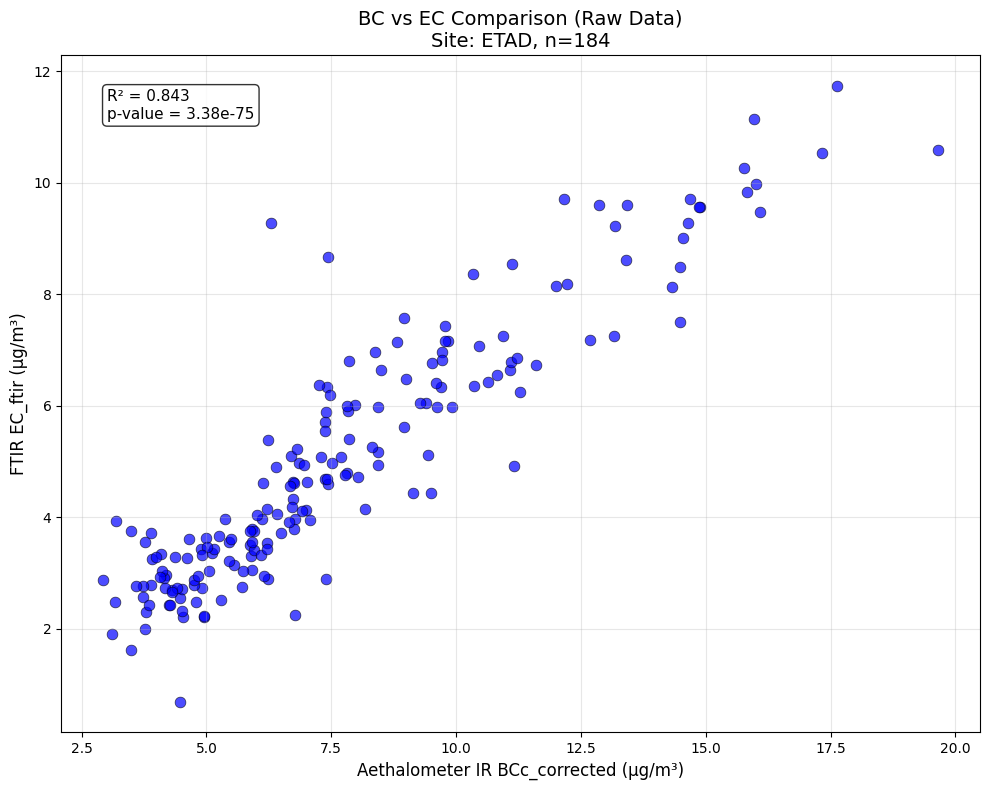

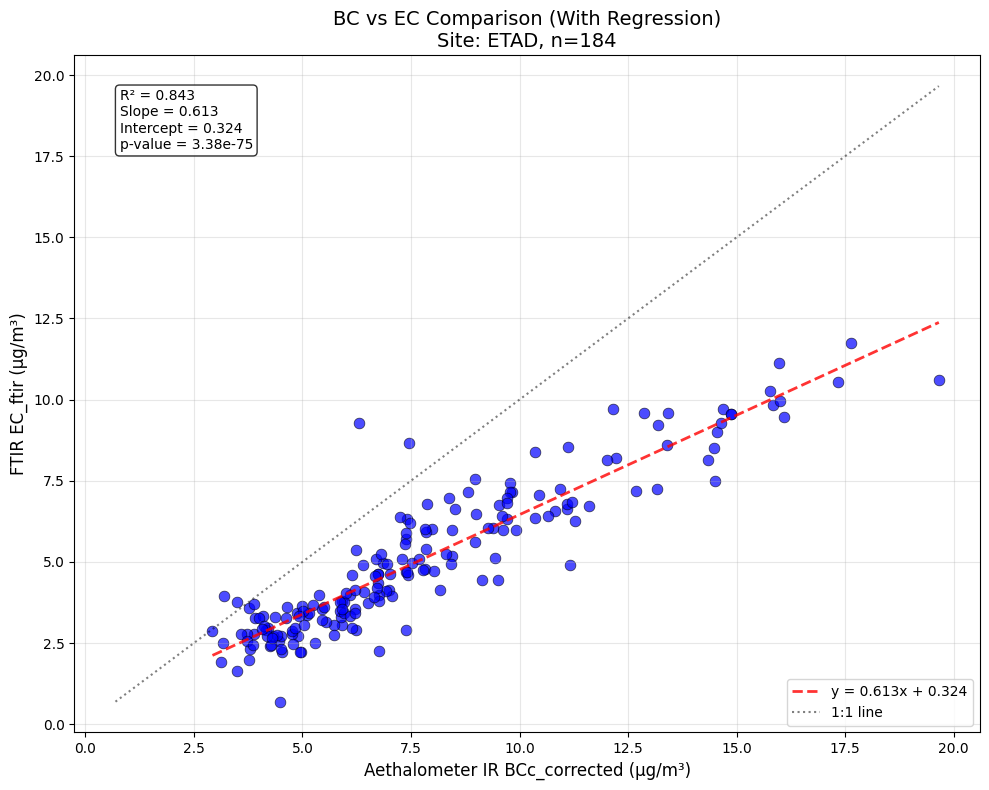

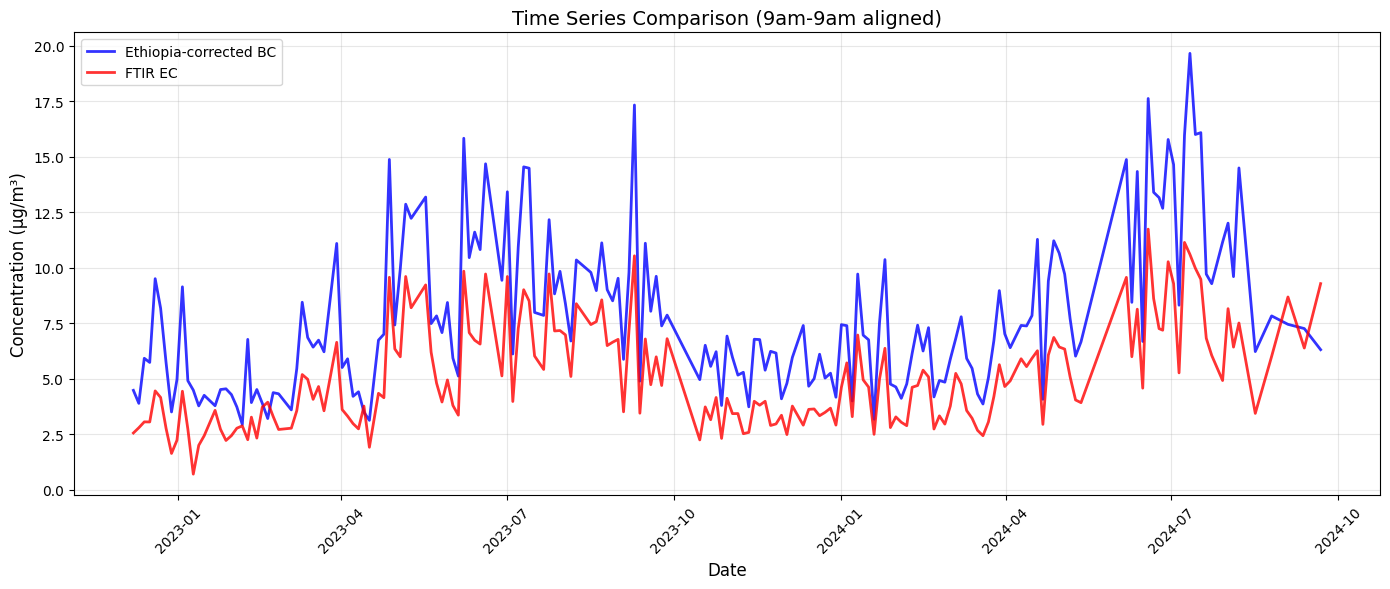

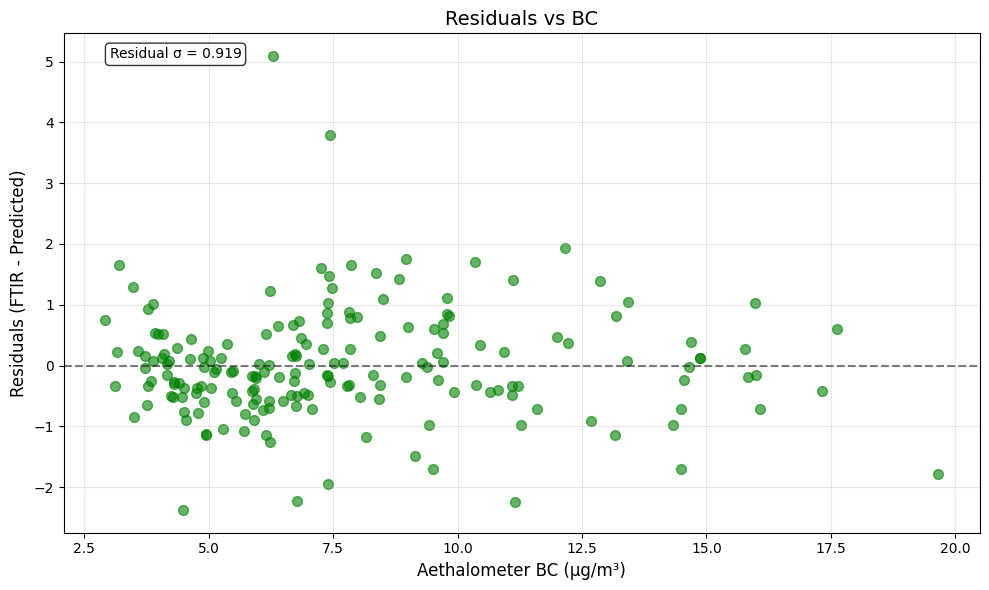


📈 COMPREHENSIVE ANALYSIS RESULTS:
🏢 Site: ETAD
🔧 BC Method: Ethiopia-corrected
📊 Data Points: 184
📅 Date Range: 2022-12-07 to 2024-09-21

📊 CORRELATION ANALYSIS:
  R² = 0.843
  Correlation (r) = 0.918
  Slope = 0.613
  Intercept = 0.324 µg/m³
  p-value = 3.38e-75
  Standard Error = 0.020

🎯 ETHIOPIA FIX ASSESSMENT:
  ✅ Using optimal Ethiopia corrections
  📊 BC-ATN1 correlation: 0.007
  🎉 Excellent fix effectiveness (low BC-ATN1 correlation)

🔬 INTERPRETATION:
  🎉 Excellent agreement between aethalometer and FTIR!
  📏 Methods are highly consistent


In [21]:
# %%
# Improved Analysis and plotting with separate individual graphs
if 'merged_data' in locals() and len(merged_data) > 0:
    print("📊 Creating individual analysis plots with explicit Ethiopia correction column selection...")
    
    # Show all available columns for transparency
    print(f"\n🔍 Available columns in merged data ({merged_data.shape[1]} total):")
    all_cols = list(merged_data.columns)
    
    # Categorize columns
    ftir_cols = [col for col in all_cols if any(x in col.lower() for x in ['ec', 'oc', 'ftir'])]
    bc_original_cols = [col for col in all_cols if 'BCc' in col and 'corrected' not in col and 'manual' not in col and 'optimized' not in col]
    bc_corrected_cols = [col for col in all_cols if 'BCc' in col and 'corrected' in col]
    bc_manual_cols = [col for col in all_cols if 'BCc' in col and 'manual' in col]
    bc_optimized_cols = [col for col in all_cols if 'BCc' in col and 'optimized' in col]
    atn_cols = [col for col in all_cols if 'ATN' in col]
    
    print(f"  🧪 FTIR columns ({len(ftir_cols)}): {ftir_cols}")
    print(f"  🔧 Original BCc columns ({len(bc_original_cols)}): {bc_original_cols}")
    print(f"  ✅ Corrected BCc columns ({len(bc_corrected_cols)}): {bc_corrected_cols}")
    print(f"  📝 Manual BCc columns ({len(bc_manual_cols)}): {bc_manual_cols}")
    print(f"  🎯 Optimized BCc columns ({len(bc_optimized_cols)}): {bc_optimized_cols}")
    print(f"  📊 ATN columns ({len(atn_cols)}): {atn_cols}")
    
    # EXPLICIT COLUMN SELECTION LOGIC
    print(f"\n🎯 Explicit Column Selection Strategy:")
    
    # 1. Find FTIR EC column
    ec_col = None
    ec_candidates = ['EC_ftir', 'EC', 'Elemental Carbon']
    for candidate in ec_candidates:
        matching_cols = [col for col in ftir_cols if candidate in col]
        if matching_cols:
            ec_col = matching_cols[0]  # Take first match
            print(f"  🧪 FTIR EC column: '{ec_col}' (found via '{candidate}')")
            break
    
    if ec_col is None and ftir_cols:
        ec_col = ftir_cols[0]  # Fallback to first FTIR column
        print(f"  🧪 FTIR EC column: '{ec_col}' (fallback - first FTIR column)")
    
    # 2. Find best BC column - explicit priority order
    bc_col = None
    bc_col_type = None
    
    # Priority 1: Ethiopia-corrected columns (highest priority)
    if bc_corrected_cols:
        # Prefer IR, then Red, then others
        wavelength_priority = ['IR', 'Red', 'Blue', 'Green', 'UV']
        for wl in wavelength_priority:
            matching = [col for col in bc_corrected_cols if wl in col]
            if matching:
                bc_col = matching[0]
                bc_col_type = "Ethiopia-corrected"
                print(f"  ✅ BC column: '{bc_col}' (Ethiopia-corrected - {wl})")
                break
        
        if bc_col is None:  # Fallback to first corrected column
            bc_col = bc_corrected_cols[0]
            bc_col_type = "Ethiopia-corrected"
            print(f"  ✅ BC column: '{bc_col}' (Ethiopia-corrected - fallback)")
    
    # Priority 2: Optimized columns
    elif bc_optimized_cols:
        bc_col = bc_optimized_cols[0]
        bc_col_type = "Ethiopia-optimized"
        print(f"  🎯 BC column: '{bc_col}' (Ethiopia-optimized)")
    
    # Priority 3: Manual columns  
    elif bc_manual_cols:
        bc_col = bc_manual_cols[0]
        bc_col_type = "Ethiopia-manual"
        print(f"  📝 BC column: '{bc_col}' (Ethiopia-manual)")
    
    # Priority 4: Original BCc columns
    elif bc_original_cols:
        # Prefer IR, then Red
        for wl in ['IR', 'Red', 'Blue']:
            matching = [col for col in bc_original_cols if wl in col]
            if matching:
                bc_col = matching[0]
                bc_col_type = "Original"
                print(f"  🔧 BC column: '{bc_col}' (Original - {wl})")
                break
        
        if bc_col is None:
            bc_col = bc_original_cols[0]
            bc_col_type = "Original"
            print(f"  🔧 BC column: '{bc_col}' (Original - fallback)")
    
    print(f"\n📋 Final Selection Summary:")
    print(f"  🧪 FTIR column: {ec_col}")
    print(f"  🔧 BC column: {bc_col} ({bc_col_type})")
    
    # Verify Ethiopia corrections are being used
    if bc_col_type == "Ethiopia-corrected":
        print(f"  🎉 SUCCESS: Using Ethiopia-corrected BC data!")
    elif bc_col_type in ["Ethiopia-optimized", "Ethiopia-manual"]:
        print(f"  ✅ GOOD: Using Ethiopia-processed BC data!")
    else:
        print(f"  ⚠️  WARNING: Using original BC data - Ethiopia corrections may not be available!")
    
    # PROCEED WITH ANALYSIS if we have both columns
    if ec_col and bc_col and ec_col in merged_data.columns and bc_col in merged_data.columns:
        
        # Prepare data - remove NaN values
        print(f"\n📊 Preparing data for analysis...")
        bc_data = merged_data[bc_col].dropna()
        ec_data = merged_data[ec_col].dropna()
        
        # Get overlapping data points
        common_idx = bc_data.index.intersection(ec_data.index)
        
        print(f"  📈 BC data points: {len(bc_data)}")
        print(f"  🧪 FTIR data points: {len(ec_data)}")
        print(f"  🔗 Overlapping points: {len(common_idx)}")
        
        if len(common_idx) > 3:
            # Convert units: BC from ng/m³ to µg/m³, EC should already be in µg/m³
            x = bc_data.loc[common_idx] / 1000  # ng/m³ → µg/m³
            y = ec_data.loc[common_idx]  # Already in µg/m³
            
            print(f"  🔄 Unit conversion: BC {bc_data.loc[common_idx].median():.0f} ng/m³ → {x.median():.2f} µg/m³")
            print(f"  📏 FTIR EC range: {y.min():.2f} - {y.max():.2f} µg/m³")
            
            # Calculate regression statistics
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            
            # Graph 1: Scatter plot WITHOUT regression line
            fig1, ax1 = plt.subplots(figsize=(10, 8))
            ax1.scatter(x, y, alpha=0.7, color='blue', s=60, edgecolor='black', linewidth=0.5)
            ax1.set_xlabel(f'Aethalometer {bc_col} (µg/m³)', fontsize=12)
            ax1.set_ylabel(f'FTIR {ec_col} (µg/m³)', fontsize=12)
            ax1.set_title(f'BC vs EC Comparison (Raw Data)\nSite: {SITE_CODE}, n={len(x)}', fontsize=14)
            ax1.grid(True, alpha=0.3)
            
            # Statistics text without regression line
            stats_text = f'R² = {r_value**2:.3f}\np-value = {p_value:.2e}'
            ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    verticalalignment='top', fontsize=11)
            
            plt.tight_layout()
            plt.show()
            
            # Graph 2: Scatter plot WITH regression line
            fig2, ax2 = plt.subplots(figsize=(10, 8))
            ax2.scatter(x, y, alpha=0.7, color='blue', s=60, edgecolor='black', linewidth=0.5)
            
            # Add regression line
            line_x = np.linspace(x.min(), x.max(), 100)
            line_y = slope * line_x + intercept
            ax2.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2, label=f'y = {slope:.3f}x + {intercept:.3f}')
            
            # 1:1 line
            max_val = max(x.max(), y.max())
            min_val = min(x.min(), y.min())
            ax2.plot([min_val, max_val], [min_val, max_val], 'k:', alpha=0.5, label='1:1 line')
            
            ax2.set_xlabel(f'Aethalometer {bc_col} (µg/m³)', fontsize=12)
            ax2.set_ylabel(f'FTIR {ec_col} (µg/m³)', fontsize=12)
            ax2.set_title(f'BC vs EC Comparison (With Regression)\nSite: {SITE_CODE}, n={len(x)}', fontsize=14)
            
            # Statistics text with regression info
            stats_text = (f'R² = {r_value**2:.3f}\n'
                         f'Slope = {slope:.3f}\n'
                         f'Intercept = {intercept:.3f}\n'
                         f'p-value = {p_value:.2e}')
            ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    verticalalignment='top', fontsize=10)
            
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Graph 3: Time series comparison
            fig3, ax3 = plt.subplots(figsize=(14, 6))
            ax3.plot(x.index, x.values, 'b-', label=f'{bc_col_type} BC', alpha=0.8, linewidth=2)
            ax3.plot(y.index, y.values, 'r-', label=f'FTIR EC', alpha=0.8, linewidth=2)
            ax3.set_xlabel('Date', fontsize=12)
            ax3.set_ylabel('Concentration (µg/m³)', fontsize=12)
            ax3.set_title('Time Series Comparison (9am-9am aligned)', fontsize=14)
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            ax3.tick_params(axis='x', rotation=45)
            plt.tight_layout()
            plt.show()
            
            # Graph 4: Residuals plot
            fig4, ax4 = plt.subplots(figsize=(10, 6))
            residuals = y - (slope * x + intercept)
            ax4.scatter(x, residuals, alpha=0.6, color='green', s=50)
            ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax4.set_xlabel(f'Aethalometer BC (µg/m³)', fontsize=12)
            ax4.set_ylabel('Residuals (FTIR - Predicted)', fontsize=12)
            ax4.set_title('Residuals vs BC', fontsize=14)
            ax4.grid(True, alpha=0.3)
            
            # Add residual statistics
            residual_std = residuals.std()
            ax4.text(0.05, 0.95, f'Residual σ = {residual_std:.3f}', 
                    transform=ax4.transAxes, fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            plt.tight_layout()
            plt.show()
            
            # COMPREHENSIVE RESULTS SUMMARY
            print(f"\n📈 COMPREHENSIVE ANALYSIS RESULTS:")
            print(f"=" * 50)
            print(f"🏢 Site: {SITE_CODE}")
            print(f"🔧 BC Method: {bc_col_type}")
            print(f"📊 Data Points: {len(x)}")
            print(f"📅 Date Range: {x.index.min().date()} to {x.index.max().date()}")
            print(f"")
            print(f"📊 CORRELATION ANALYSIS:")
            print(f"  R² = {r_value**2:.3f}")
            print(f"  Correlation (r) = {r_value:.3f}")
            print(f"  Slope = {slope:.3f}")
            print(f"  Intercept = {intercept:.3f} µg/m³")
            print(f"  p-value = {p_value:.2e}")
            print(f"  Standard Error = {std_err:.3f}")
            
            # Show Ethiopia fix assessment if ATN data available
            atn_col = None
            for col in atn_cols:
                if any(wl in col for wl in ['IR', 'Red']) and 'ATN1' in col:
                    atn_col = col
                    break
                    
            if atn_col and atn_col in merged_data.columns:
                atn_data = merged_data.loc[common_idx, atn_col]
                bc_atn_corr = x.corr(atn_data)
                
                print(f"\n🎯 ETHIOPIA FIX ASSESSMENT:")
                if bc_col_type == "Ethiopia-corrected":
                    print(f"  ✅ Using optimal Ethiopia corrections")
                    print(f"  📊 BC-ATN1 correlation: {bc_atn_corr:.3f}")
                    if abs(bc_atn_corr) < 0.1:
                        print(f"  🎉 Excellent fix effectiveness (low BC-ATN1 correlation)")
                    elif abs(bc_atn_corr) < 0.2:
                        print(f"  👍 Good fix effectiveness")
                    else:
                        print(f"  ⚠️ Fix may need refinement")
                elif bc_col_type in ["Ethiopia-optimized", "Ethiopia-manual"]:
                    print(f"  ✅ Using Ethiopia-processed data")
                else:
                    print(f"  ⚠️ Using original data - no Ethiopia corrections applied")
            
            print(f"\n🔬 INTERPRETATION:")
            if r_value**2 > 0.8:
                print(f"  🎉 Excellent agreement between aethalometer and FTIR!")
                print(f"  📏 Methods are highly consistent")
            elif r_value**2 > 0.6:
                print(f"  👍 Good agreement between methods")
                print(f"  📊 Strong linear relationship")
            elif r_value**2 > 0.4:
                print(f"  📊 Moderate agreement - acceptable for research")
                print(f"  🔍 Consider data quality or methodological differences")
            elif r_value**2 > 0.2:
                print(f"  ⚠️ Weak agreement - investigate data quality")
                print(f"  🔧 May need additional corrections or filtering")
            else:
                print(f"  ❌ Poor agreement - significant issues present")
                print(f"  🚨 Requires thorough investigation")
                
        else:
            print(f"⚠️ Insufficient overlapping data points ({len(common_idx)}) for analysis")
            print(f"  📊 BC data points: {len(bc_data)}")
            print(f"  🧪 FTIR data points: {len(ec_data)}")
            print(f"  📅 Date range overlap issue - check temporal alignment")
            
    else:
        print(f"❌ Cannot proceed with analysis:")
        if not ec_col:
            print(f"  🧪 No FTIR EC column found")
        elif ec_col not in merged_data.columns:
            print(f"  🧪 FTIR column '{ec_col}' not in merged data")
        if not bc_col:
            print(f"  🔧 No BC column found")
        elif bc_col not in merged_data.columns:
            print(f"  🔧 BC column '{bc_col}' not in merged data")
            
        print(f"\n🔍 Available columns for debugging:")
        for i, col in enumerate(merged_data.columns):
            print(f"    {i:2d}. {col}")

else:
    print("❌ No merged data available for analysis - check previous steps")

🔧 Applying Linear Regression Correction Based on FTIR Relationship...
Transformation: IR BCc * 0.85 - 0.17 (μg/m³)
📊 Using BC column: IR BCc_corrected
🧪 Using FTIR column: EC_ftir

✅ Applied Linear Regression Correction:
  📏 Original BC range: 2.93 - 19.66 μg/m³
  🔧 Corrected BC range: 2.32 - 16.54 μg/m³
  🧪 FTIR EC range: 0.69 - 11.74 μg/m³

📊 Correction Impact:
  Before: R² = 0.843, Slope = 0.613, Intercept = 0.324
  After:  R² = 0.843, Slope = 0.721, Intercept = 0.447
  Improvement: ΔR² = -0.000


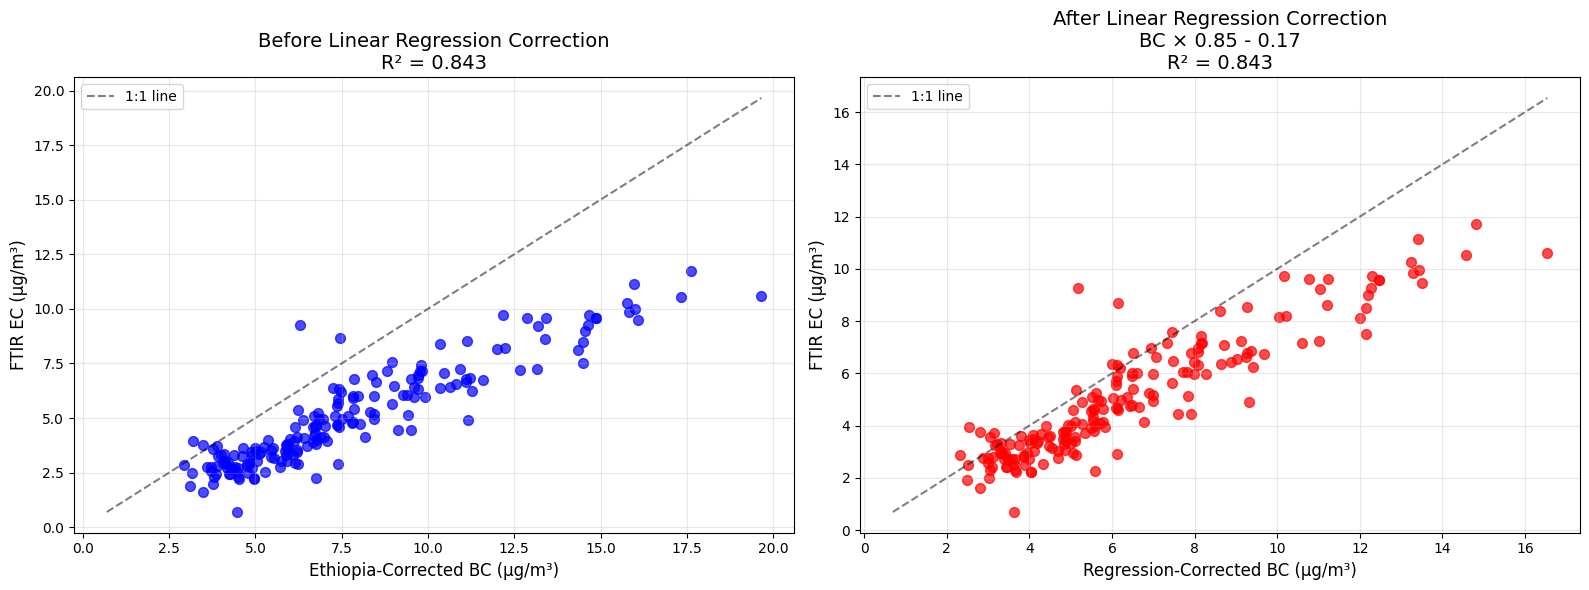

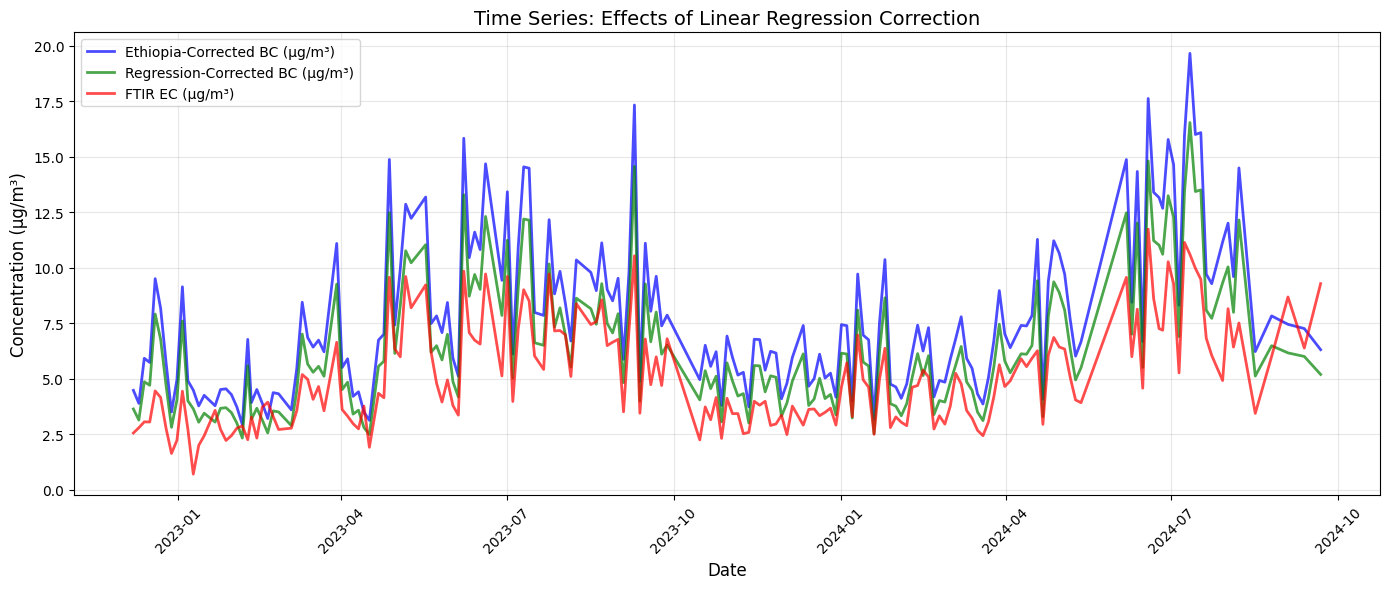

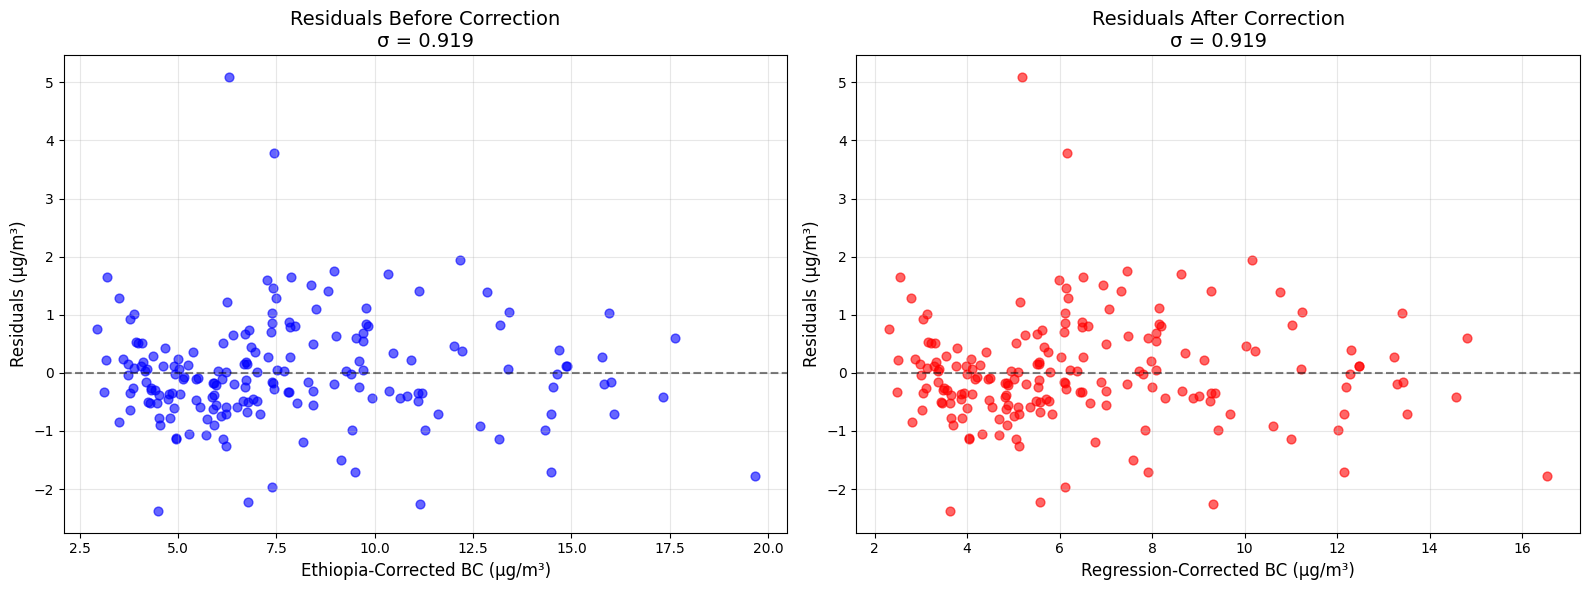


💾 Added 'BC_regression_corrected_ug' column to merged data
📊 Linear Regression Correction Summary:
  🔧 Applied transformation: BC × 0.85 - 0.17
  📈 R² improvement: 0.843 → 0.843
  📏 Residual std reduction: 0.919 → 0.919
  ⚠️ Correction did not improve agreement
  📐 Deviation from 1:1 line: 0.711 → 0.726


In [22]:
# %%
# Apply Linear Regression Correction: IR BCc * 0.85 - 0.17
print("🔧 Applying Linear Regression Correction Based on FTIR Relationship...")
print("Transformation: IR BCc * 0.85 - 0.17 (μg/m³)")

if 'merged_data' in locals() and len(merged_data) > 0:
    # Find the Ethiopia-corrected BC column and FTIR EC column (reuse previous logic)
    all_cols = list(merged_data.columns)
    
    # Find BC column (same logic as previous cell)
    bc_corrected_cols = [col for col in all_cols if 'BCc' in col and 'corrected' in col]
    bc_col = None
    
    if bc_corrected_cols:
        wavelength_priority = ['IR', 'Red', 'Blue', 'Green', 'UV']
        for wl in wavelength_priority:
            matching = [col for col in bc_corrected_cols if wl in col]
            if matching:
                bc_col = matching[0]
                break
        if bc_col is None:
            bc_col = bc_corrected_cols[0]
    
    # Find FTIR EC column
    ftir_cols = [col for col in all_cols if any(x in col.lower() for x in ['ec', 'oc', 'ftir'])]
    ec_col = None
    ec_candidates = ['EC_ftir', 'EC', 'Elemental Carbon']
    for candidate in ec_candidates:
        matching_cols = [col for col in ftir_cols if candidate in col]
        if matching_cols:
            ec_col = matching_cols[0]
            break
    if ec_col is None and ftir_cols:
        ec_col = ftir_cols[0]
    
    print(f"📊 Using BC column: {bc_col}")
    print(f"🧪 Using FTIR column: {ec_col}")
    
    if bc_col and ec_col and bc_col in merged_data.columns and ec_col in merged_data.columns:
        # Get overlapping data
        bc_data = merged_data[bc_col].dropna()
        ec_data = merged_data[ec_col].dropna()
        common_idx = bc_data.index.intersection(ec_data.index)
        
        if len(common_idx) > 3:
            # Convert units: BC from ng/m³ to µg/m³
            bc_original_ug = bc_data.loc[common_idx] / 1000  # Original BC in μg/m³
            ec_ftir = ec_data.loc[common_idx]  # FTIR EC in μg/m³
            
            # Apply linear regression correction: BC * 0.85 - 0.17
            bc_regression_corrected = bc_original_ug * 0.85 - 0.17
            
            print(f"\n✅ Applied Linear Regression Correction:")
            print(f"  📏 Original BC range: {bc_original_ug.min():.2f} - {bc_original_ug.max():.2f} μg/m³")
            print(f"  🔧 Corrected BC range: {bc_regression_corrected.min():.2f} - {bc_regression_corrected.max():.2f} μg/m³")
            print(f"  🧪 FTIR EC range: {ec_ftir.min():.2f} - {ec_ftir.max():.2f} μg/m³")
            
            # Calculate correlations before and after
            from scipy import stats
            
            # Before correction
            slope_before, intercept_before, r_before, p_before, _ = stats.linregress(bc_original_ug, ec_ftir)
            
            # After correction  
            slope_after, intercept_after, r_after, p_after, _ = stats.linregress(bc_regression_corrected, ec_ftir)
            
            print(f"\n📊 Correction Impact:")
            print(f"  Before: R² = {r_before**2:.3f}, Slope = {slope_before:.3f}, Intercept = {intercept_before:.3f}")
            print(f"  After:  R² = {r_after**2:.3f}, Slope = {slope_after:.3f}, Intercept = {intercept_after:.3f}")
            print(f"  Improvement: ΔR² = {(r_after**2 - r_before**2):.3f}")
            
            # Graph 5: Before vs After Linear Regression Correction
            fig5, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            # Before correction
            ax1.scatter(bc_original_ug, ec_ftir, alpha=0.7, color='blue', s=50)
            ax1.set_xlabel('Ethiopia-Corrected BC (μg/m³)', fontsize=12)
            ax1.set_ylabel('FTIR EC (μg/m³)', fontsize=12)
            ax1.set_title(f'Before Linear Regression Correction\nR² = {r_before**2:.3f}', fontsize=14)
            ax1.grid(True, alpha=0.3)
            
            # Add 1:1 line
            min_val = min(bc_original_ug.min(), ec_ftir.min())
            max_val = max(bc_original_ug.max(), ec_ftir.max())
            ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='1:1 line')
            ax1.legend()
            
            # After correction
            ax2.scatter(bc_regression_corrected, ec_ftir, alpha=0.7, color='red', s=50)
            ax2.set_xlabel('Regression-Corrected BC (μg/m³)', fontsize=12)
            ax2.set_ylabel('FTIR EC (μg/m³)', fontsize=12)
            ax2.set_title(f'After Linear Regression Correction\nBC × 0.85 - 0.17\nR² = {r_after**2:.3f}', fontsize=14)
            ax2.grid(True, alpha=0.3)
            
            # Add 1:1 line
            min_val_after = min(bc_regression_corrected.min(), ec_ftir.min())
            max_val_after = max(bc_regression_corrected.max(), ec_ftir.max())
            ax2.plot([min_val_after, max_val_after], [min_val_after, max_val_after], 'k--', alpha=0.5, label='1:1 line')
            ax2.legend()
            
            plt.tight_layout()
            plt.show()
            
            # Graph 6: Time Series with Linear Regression Correction
            fig6, ax6 = plt.subplots(figsize=(14, 6))
            ax6.plot(bc_original_ug.index, bc_original_ug.values, 'b-', 
                    label='Ethiopia-Corrected BC (μg/m³)', alpha=0.7, linewidth=2)
            ax6.plot(bc_regression_corrected.index, bc_regression_corrected.values, 'g-', 
                    label='Regression-Corrected BC (μg/m³)', alpha=0.7, linewidth=2)
            ax6.plot(ec_ftir.index, ec_ftir.values, 'r-', 
                    label='FTIR EC (μg/m³)', alpha=0.7, linewidth=2)
            ax6.set_xlabel('Date', fontsize=12)
            ax6.set_ylabel('Concentration (μg/m³)', fontsize=12)
            ax6.set_title('Time Series: Effects of Linear Regression Correction', fontsize=14)
            ax6.legend()
            ax6.grid(True, alpha=0.3)
            ax6.tick_params(axis='x', rotation=45)
            plt.tight_layout()
            plt.show()
            
            # Graph 7: Residuals Comparison
            fig7, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            # Residuals before correction
            residuals_before = ec_ftir - (slope_before * bc_original_ug + intercept_before)
            ax1.scatter(bc_original_ug, residuals_before, alpha=0.6, color='blue', s=40)
            ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax1.set_xlabel('Ethiopia-Corrected BC (μg/m³)', fontsize=12)
            ax1.set_ylabel('Residuals (μg/m³)', fontsize=12)
            ax1.set_title(f'Residuals Before Correction\nσ = {residuals_before.std():.3f}', fontsize=14)
            ax1.grid(True, alpha=0.3)
            
            # Residuals after correction
            residuals_after = ec_ftir - (slope_after * bc_regression_corrected + intercept_after)
            ax2.scatter(bc_regression_corrected, residuals_after, alpha=0.6, color='red', s=40)
            ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax2.set_xlabel('Regression-Corrected BC (μg/m³)', fontsize=12)
            ax2.set_ylabel('Residuals (μg/m³)', fontsize=12)
            ax2.set_title(f'Residuals After Correction\nσ = {residuals_after.std():.3f}', fontsize=14)
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Store corrected data in merged_data for further use
            merged_data['BC_regression_corrected_ug'] = np.nan
            merged_data.loc[common_idx, 'BC_regression_corrected_ug'] = bc_regression_corrected
            
            print(f"\n💾 Added 'BC_regression_corrected_ug' column to merged data")
            print(f"📊 Linear Regression Correction Summary:")
            print(f"  🔧 Applied transformation: BC × 0.85 - 0.17")
            print(f"  📈 R² improvement: {r_before**2:.3f} → {r_after**2:.3f}")
            print(f"  📏 Residual std reduction: {residuals_before.std():.3f} → {residuals_after.std():.3f}")
            
            if r_after**2 > r_before**2:
                print(f"  ✅ Correction improved agreement with FTIR!")
            else:
                print(f"  ⚠️ Correction did not improve agreement")
                
            # Show how close we get to 1:1 relationship
            deviation_from_unity_before = abs(slope_before - 1.0) + abs(intercept_before)
            deviation_from_unity_after = abs(slope_after - 1.0) + abs(intercept_after)
            
            print(f"  📐 Deviation from 1:1 line: {deviation_from_unity_before:.3f} → {deviation_from_unity_after:.3f}")
            
            if deviation_from_unity_after < deviation_from_unity_before:
                print(f"  🎯 Closer to ideal 1:1 relationship!")
            
        else:
            print(f"⚠️ Insufficient overlapping data ({len(common_idx)} points)")
            
    else:
        print(f"❌ Required columns not found:")
        print(f"  BC column '{bc_col}': {'✅' if bc_col in merged_data.columns else '❌'}")
        print(f"  EC column '{ec_col}': {'✅' if ec_col in merged_data.columns else '❌'}")
        
else:
    print("❌ No merged data available - run previous cells first")

In [23]:
# Save results and summary
if 'merged_data' in locals() and len(merged_data) > 0:
    print("💾 Saving results...")
    
    # Save merged data
    output_file = f"aethalometer_ftir_merged_{SITE_CODE.lower()}_9am.pkl"
    merged_data.to_pickle(output_file)
    print(f"✅ Saved merged data to: {output_file}")
    
    # Save as CSV for easy viewing
    csv_file = f"aethalometer_ftir_merged_{SITE_CODE.lower()}_9am.csv"
    merged_data.to_csv(csv_file)
    print(f"✅ Saved CSV version to: {csv_file}")
    
    print(f"\n📋 Final Summary:")
    print(f"  🏢 Site: {SITE_CODE}")
    print(f"  📊 Total merged data points: {len(merged_data)}")
    print(f"  📅 Date range: {merged_data.index.min()} to {merged_data.index.max()}")
    print(f"  🔧 Aethalometer columns: {len([c for c in merged_data.columns if any(x in c for x in ['BCc', 'BC1', 'ATN'])])}")
    print(f"  🧪 FTIR columns: {len([c for c in merged_data.columns if any(x in c.lower() for x in ['ec', 'oc'])])}")
    
else:
    print("⚠️ No data to save")

print(f"\n🎯 Pipeline Complete!")
print(f"✅ FTIR data loaded from CSV")
print(f"✅ 9am-to-9am alignment applied")
print(f"✅ Data merged and analyzed")
print(f"✅ Results saved")

💾 Saving results...
✅ Saved merged data to: aethalometer_ftir_merged_etad_9am.pkl
✅ Saved CSV version to: aethalometer_ftir_merged_etad_9am.csv

📋 Final Summary:
  🏢 Site: ETAD
  📊 Total merged data points: 189
  📅 Date range: 2022-12-07 09:00:00+03:00 to 2024-09-21 09:00:00+03:00
  🔧 Aethalometer columns: 76
  🧪 FTIR columns: 9

🎯 Pipeline Complete!
✅ FTIR data loaded from CSV
✅ 9am-to-9am alignment applied
✅ Data merged and analyzed
✅ Results saved


In [24]:
# %%
# Optional: Load and integrate speciation data
print("🧪 SPECIATION DATA INTEGRATION MODULE")
print("="*50)

# Set the path to your speciation CSV file (update this path as needed)
SPECIATION_CSV_PATH = "/path/to/your/speciation_data.csv"  # Update this path!

# Example usage of the speciation module
print("📋 How to use the speciation data module:")
print()
print("1️⃣ Load speciation data:")
print("   speciation_data = load_etad_speciation_data(SPECIATION_CSV_PATH)")
print()
print("2️⃣ Merge with FTIR data:")
print("   combined_data = merge_etad_datasets(ftir_data, speciation_data)")
print()
print("3️⃣ Available chemical species after loading:")
print("   📊 Ions: Sulfate, Nitrate, Ammonium, Potassium, Sodium, Calcium, etc.")
print("   🔬 Metals: Iron, Aluminum, Zinc, Lead, Copper, Manganese, etc.")
print("   📈 Ratios: K/PM2.5, Fe/Al, SO4/NO3 (auto-calculated)")
print("   🌍 Seasons: Ethiopian seasonal classification (Bega, Belg, Kiremt)")
print()
print("4️⃣ Data processing features:")
print("   ✅ Automatic unit conversion (ng/m³ → μg/m³)")
print("   ✅ Parameter code mapping (28101 → PM25_mass, etc.)")
print("   ✅ Filter ID and date-based merging")
print("   ✅ Ethiopian seasonal classification")
print("   ✅ Source apportionment ratios")

# Uncomment and update the path below to actually load speciation data
# if Path(SPECIATION_CSV_PATH).exists():
#     print(f"\n🔄 Loading speciation data from: {SPECIATION_CSV_PATH}")
#     
#     # Load speciation data
#     speciation_data = load_etad_speciation_data(SPECIATION_CSV_PATH)
#     
#     if speciation_data is not None:
#         print(f"✅ Loaded speciation data: {speciation_data.shape}")
#         print(f"📊 Available species: {list(speciation_data.columns)}")
#         
#         # If we have FTIR data, try to merge
#         if 'ftir_data' in locals():
#             combined_data = merge_etad_datasets(ftir_data, speciation_data)
#             
#             if combined_data is not None:
#                 print(f"🎉 Successfully created combined dataset: {combined_data.shape}")
#                 
#                 # Show available data types
#                 ftir_cols = [col for col in combined_data.columns if 'ftir' in col.lower()]
#                 spec_cols = [col for col in combined_data.columns if any(x in col for x in ['Ion', 'PM25', 'ratio'])]
#                 metal_cols = [col for col in combined_data.columns if any(x in col for x in ['Iron', 'Aluminum', 'Zinc', 'Lead'])]
#                 
#                 print(f"  🧪 FTIR columns: {len(ftir_cols)} - {ftir_cols}")
#                 print(f"  🧂 Ion/PM columns: {len(spec_cols)} - {spec_cols[:5]}...")
#                 print(f"  🔬 Metal columns: {len(metal_cols)} - {metal_cols[:5]}...")
#                 
#                 # Show seasonal distribution
#                 if 'season' in combined_data.columns:
#                     season_counts = combined_data['season'].value_counts()
#                     print(f"  🌍 Seasonal distribution: {dict(season_counts)}")
#                 
#                 # Example correlation analysis
#                 if 'EC_ftir' in combined_data.columns and 'Potassium_Ion' in combined_data.columns:
#                     correlation = combined_data['EC_ftir'].corr(combined_data['Potassium_Ion'])
#                     print(f"  📈 Example: EC_ftir vs K+ correlation = {correlation:.3f}")
#         
#         else:
#             print("⚠️ No FTIR data available for merging")
#     
# else:
#     print(f"⚠️ Speciation file not found: {SPECIATION_CSV_PATH}")
#     print("📝 To use speciation data:")
#     print("   1. Update SPECIATION_CSV_PATH to point to your speciation CSV file")
#     print("   2. Uncomment the loading code above")
#     print("   3. Run this cell again")

print(f"\n📚 Module Summary:")
print(f"✅ FTIR CSV loader: Ready")
print(f"✅ Speciation data loader: Ready") 
print(f"✅ Dataset merger: Ready")
print(f"✅ 9AM-to-9AM resampling: Ready")
print(f"✅ Site configurations: ETAD, JPL, INDH, Beijing")
print(f"")
print(f"🎯 This modular system allows you to:")
print(f"  📊 Load FTIR data from CSV files")
print(f"  🧪 Load chemical speciation data")
print(f"  🔗 Merge datasets by filter ID or date")
print(f"  ⏰ Apply 9AM-to-9AM daily averaging")
print(f"  🌍 Handle multiple site configurations")
print(f"  📈 Calculate source apportionment ratios")
print(f"  🌦️ Apply seasonal classifications")

🧪 SPECIATION DATA INTEGRATION MODULE
📋 How to use the speciation data module:

1️⃣ Load speciation data:
   speciation_data = load_etad_speciation_data(SPECIATION_CSV_PATH)

2️⃣ Merge with FTIR data:
   combined_data = merge_etad_datasets(ftir_data, speciation_data)

3️⃣ Available chemical species after loading:
   📊 Ions: Sulfate, Nitrate, Ammonium, Potassium, Sodium, Calcium, etc.
   🔬 Metals: Iron, Aluminum, Zinc, Lead, Copper, Manganese, etc.
   📈 Ratios: K/PM2.5, Fe/Al, SO4/NO3 (auto-calculated)
   🌍 Seasons: Ethiopian seasonal classification (Bega, Belg, Kiremt)

4️⃣ Data processing features:
   ✅ Automatic unit conversion (ng/m³ → μg/m³)
   ✅ Parameter code mapping (28101 → PM25_mass, etc.)
   ✅ Filter ID and date-based merging
   ✅ Ethiopian seasonal classification
   ✅ Source apportionment ratios

📚 Module Summary:
✅ FTIR CSV loader: Ready
✅ Speciation data loader: Ready
✅ Dataset merger: Ready
✅ 9AM-to-9AM resampling: Ready
✅ Site configurations: ETAD, JPL, INDH, Beijing

🎯 T

In [ ]:
# %%
# Analysis with ORIGINAL BCC data vs FTIR (before Ethiopia corrections)
print("🔧 Creating analysis with ORIGINAL BCC data (before Ethiopia corrections)...")

if 'merged_data' in locals() and len(merged_data) > 0:
    # Find original BCc columns (not corrected/manual/optimized)
    all_cols = list(merged_data.columns)
    bc_original_cols = [col for col in all_cols if 'BCc' in col and 
                       'corrected' not in col and 'manual' not in col and 'optimized' not in col]
    
    # Find FTIR EC column (reuse previous logic)
    ftir_cols = [col for col in all_cols if any(x in col.lower() for x in ['ec', 'oc', 'ftir'])]
    ec_col = None
    ec_candidates = ['EC_ftir', 'EC', 'Elemental Carbon']
    for candidate in ec_candidates:
        matching_cols = [col for col in ftir_cols if candidate in col]
        if matching_cols:
            ec_col = matching_cols[0]
            break
    if ec_col is None and ftir_cols:
        ec_col = ftir_cols[0]
    
    # Select original BC column (prefer IR, then others)
    bc_original_col = None
    if bc_original_cols:
        wavelength_priority = ['IR', 'Red', 'Blue', 'Green', 'UV']
        for wl in wavelength_priority:
            matching = [col for col in bc_original_cols if wl in col and 'smoothed' not in col and 'denominator' not in col]
            if matching:
                bc_original_col = matching[0]
                break
        if bc_original_col is None:
            bc_original_col = bc_original_cols[0]
    
    print(f"📊 Using original BC column: {bc_original_col}")
    print(f"🧪 Using FTIR column: {ec_col}")
    print(f"🔍 Available original BCc columns: {bc_original_cols}")
    
    if bc_original_col and ec_col and bc_original_col in merged_data.columns and ec_col in merged_data.columns:
        # Get overlapping data
        bc_original_data = merged_data[bc_original_col].dropna()
        ec_data = merged_data[ec_col].dropna()
        common_idx = bc_original_data.index.intersection(ec_data.index)
        
        print(f"📈 Original BC data points: {len(bc_original_data)}")
        print(f"🧪 FTIR data points: {len(ec_data)}")
        print(f"🔗 Overlapping points: {len(common_idx)}")
        
        if len(common_idx) > 3:
            # Convert units: BC from ng/m³ to µg/m³
            x_original = bc_original_data.loc[common_idx] / 1000  # ng/m³ → µg/m³
            y = ec_data.loc[common_idx]  # Already in µg/m³
            
            print(f"🔄 Unit conversion: Original BC {bc_original_data.loc[common_idx].median():.0f} ng/m³ → {x_original.median():.2f} µg/m³")
            
            # Calculate regression statistics
            from scipy import stats
            slope_orig, intercept_orig, r_orig, p_orig, std_err_orig = stats.linregress(x_original, y)
            
            print(f"\n📊 ORIGINAL BC vs FTIR ANALYSIS:")
            print(f"  R² = {r_orig**2:.3f}")
            print(f"  Slope = {slope_orig:.3f}")
            print(f"  Intercept = {intercept_orig:.3f}")
            print(f"  p-value = {p_orig:.2e}")
            
            # Graph 1: Scatter plot with regression line
            fig1, ax1 = plt.subplots(figsize=(10, 8))
            ax1.scatter(x_original, y, alpha=0.7, color='orange', s=60, edgecolor='black', linewidth=0.5)
            
            # Add regression line
            line_x = np.linspace(x_original.min(), x_original.max(), 100)
            line_y = slope_orig * line_x + intercept_orig
            ax1.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2, 
                    label=f'y = {slope_orig:.3f}x + {intercept_orig:.3f}')
            
            # 1:1 line
            max_val = max(x_original.max(), y.max())
            min_val = min(x_original.min(), y.min())
            ax1.plot([min_val, max_val], [min_val, max_val], 'k:', alpha=0.5, label='1:1 line')
            
            ax1.set_xlabel(f'Original {bc_original_col} (µg/m³)', fontsize=12)
            ax1.set_ylabel(f'FTIR {ec_col} (µg/m³)', fontsize=12)
            ax1.set_title(f'Original BC vs FTIR EC\nR² = {r_orig**2:.3f}, n={len(x_original)}', fontsize=14)
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Graph 2: Residuals
            fig2, ax2 = plt.subplots(figsize=(10, 6))
            residuals_orig = y - (slope_orig * x_original + intercept_orig)
            ax2.scatter(x_original, residuals_orig, alpha=0.6, color='orange', s=50)
            ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax2.set_xlabel(f'Original BC (µg/m³)', fontsize=12)
            ax2.set_ylabel('Residuals (µg/m³)', fontsize=12)
            ax2.set_title(f'Residuals vs Original BC\nσ = {residuals_orig.std():.3f}', fontsize=14)
            ax2.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Graph 3: Time series
            fig3, ax3 = plt.subplots(figsize=(14, 6))
            ax3.plot(x_original.index, x_original.values, 'orange', label=f'Original BC', alpha=0.8, linewidth=2)
            ax3.plot(y.index, y.values, 'red', label=f'FTIR EC', alpha=0.8, linewidth=2)
            ax3.set_xlabel('Date', fontsize=12)
            ax3.set_ylabel('Concentration (µg/m³)', fontsize=12)
            ax3.set_title('Time Series: Original BC vs FTIR EC', fontsize=14)
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            ax3.tick_params(axis='x', rotation=45)
            plt.tight_layout()
            plt.show()
            
            # Graph 4: Data distribution comparison
            fig4, ax4 = plt.subplots(figsize=(10, 6))
            ax4.hist(x_original, bins=20, alpha=0.5, label='Original BC', color='orange', density=True)
            ax4.hist(y, bins=20, alpha=0.5, label='FTIR EC', color='red', density=True)
            ax4.set_xlabel('Concentration (µg/m³)', fontsize=12)
            ax4.set_ylabel('Density', fontsize=12)
            ax4.set_title('Distribution Comparison', fontsize=14)
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print(f"\n🔬 INTERPRETATION OF ORIGINAL BC DATA:")
            if r_orig**2 > 0.6:
                print(f"  👍 Good agreement even with original BC data (R² = {r_orig**2:.3f})")
                print(f"  📊 Ethiopia corrections may provide additional refinement")
            elif r_orig**2 > 0.4:
                print(f"  📊 Moderate agreement with original BC (R² = {r_orig**2:.3f})")
                print(f"  🔧 Ethiopia corrections likely improve performance")
            else:
                print(f"  ⚠️ Poor agreement with original BC (R² = {r_orig**2:.3f})")
                print(f"  🚨 Ethiopia corrections are essential for this dataset")
            
            # Compare with ideal 1:1 relationship
            deviation_orig = abs(slope_orig - 1.0) + abs(intercept_orig)
            print(f"  📐 Deviation from 1:1 line: {deviation_orig:.3f}")
            
            if slope_orig > 1.2:
                print(f"  ⬆️ BC systematically higher than FTIR EC")
            elif slope_orig < 0.8:
                print(f"  ⬇️ BC systematically lower than FTIR EC")
            else:
                print(f"  ⚖️ BC and FTIR EC in reasonable agreement")
                
        else:
            print(f"⚠️ Insufficient overlapping data points ({len(common_idx)}) for original BC analysis")
    else:
        print(f"❌ Cannot proceed with original BC analysis:")
        if not bc_original_col:
            print(f"  🔧 No original BC column found")
        elif bc_original_col not in merged_data.columns:
            print(f"  🔧 Original BC column '{bc_original_col}' not in merged data")
        if not ec_col:
            print(f"  🧪 No FTIR EC column found")
        elif ec_col not in merged_data.columns:
            print(f"  🧪 FTIR column '{ec_col}' not in merged data")
else:
    print("❌ No merged data available for original BC analysis")

🎯 FOUR-WAY COMPARISON: Corrected BC vs Original BC vs FTIR EC vs Regression-Corrected BC
📊 Using original BC column: IR BCc
✅ Using corrected BC column: IR BCc_corrected
🧪 Using FTIR column: EC_ftir
📈 Using regression-corrected BC column: BC_regression_corrected_ug
🔍 Available columns: 3/3 required + 1/1 optional

📊 Data Coverage (Four-Way):
  📈 Original BC data points: 184
  ✅ Corrected BC data points: 184
  🧪 FTIR data points: 189
  📈 Regression-corrected BC data points: 184
  🔗 Four-way overlapping points: 184

🔄 Unit Conversions:
  📈 Original BC: 6770 ng/m³ → 6.77 µg/m³
  ✅ Corrected BC: 6829 ng/m³ → 6.83 µg/m³
  🧪 FTIR EC: 4.61 µg/m³
  📈 Regression-corrected BC: 5.63 µg/m³

📊 CORRELATION ANALYSIS:
  🔧 Original BC vs FTIR:     R² = 0.703, Slope = 0.520
  ✅ Corrected BC vs FTIR:    R² = 0.843, Slope = 0.613
  📈 Regression BC vs FTIR:   R² = 0.843, Slope = 0.721
  🔄 Original vs Corrected:   R² = 0.863, Slope = 0.864
  🔄 Original vs Regression:  R² = 0.863, Slope = 0.734


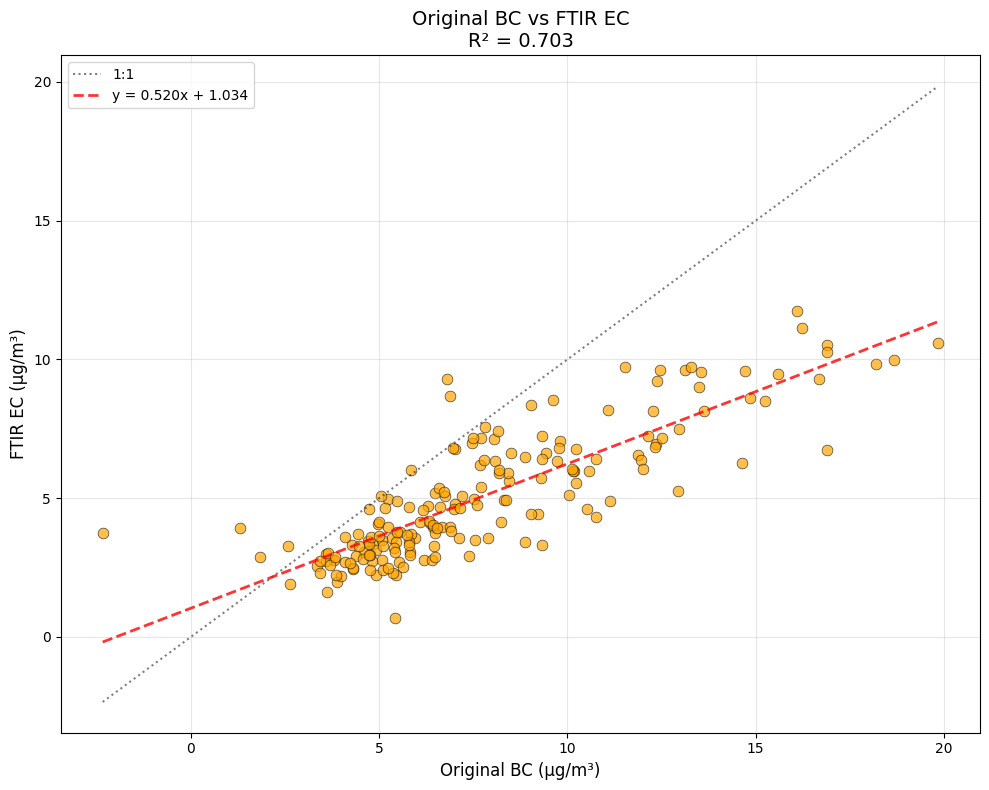

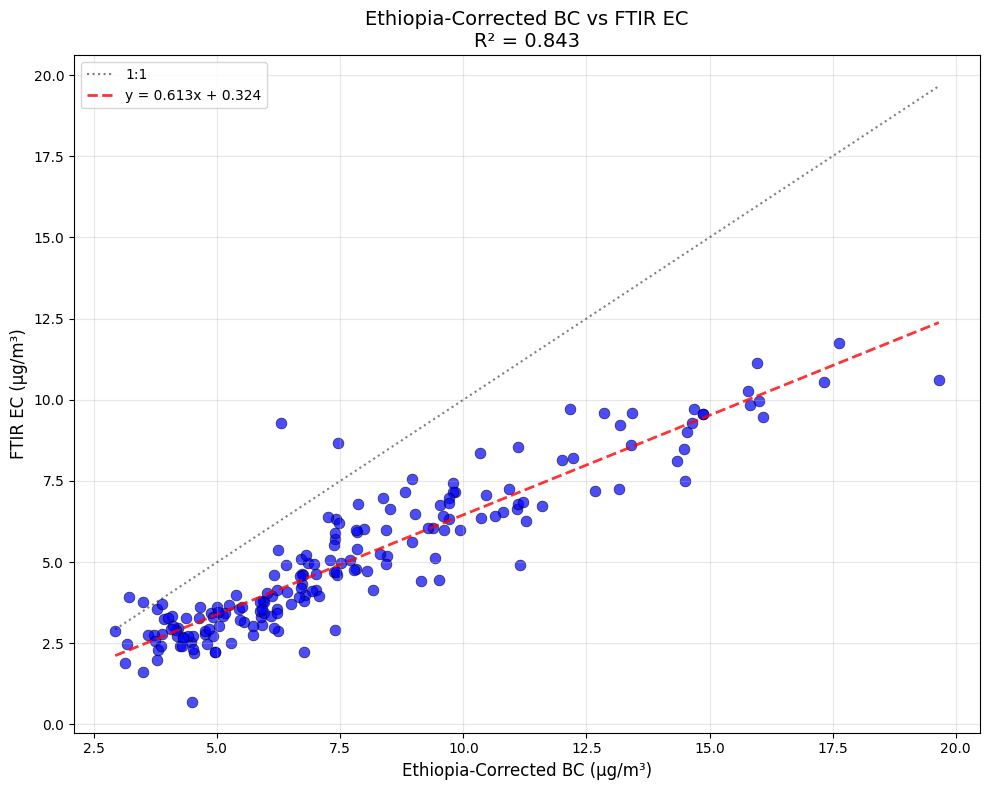

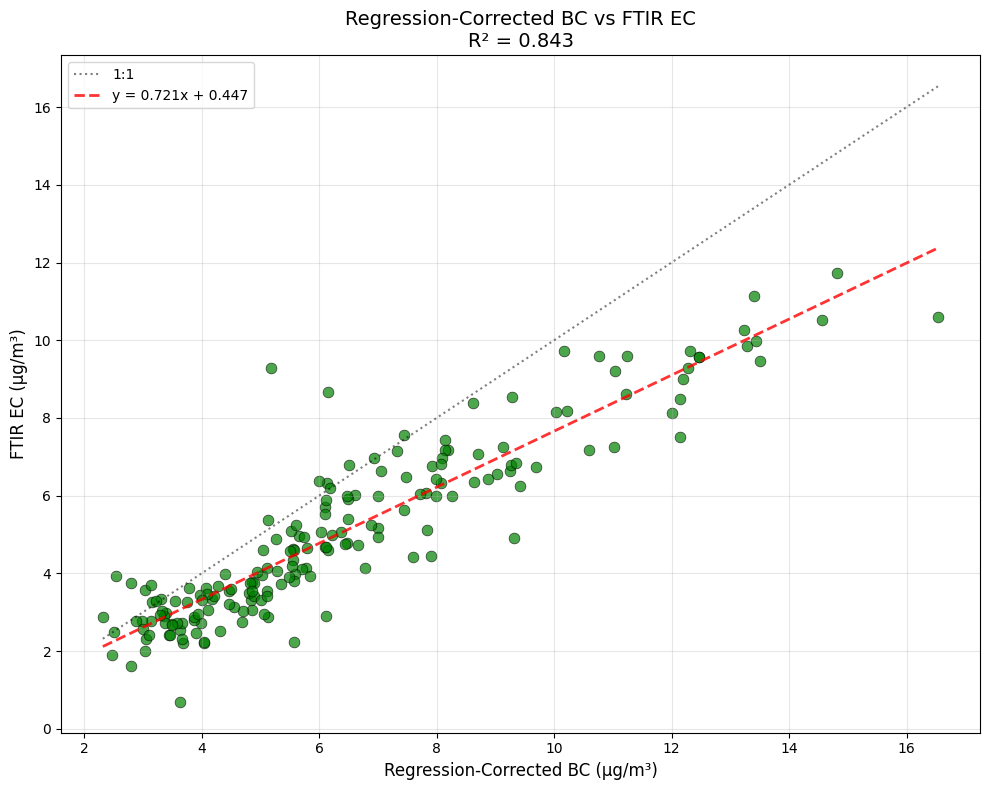

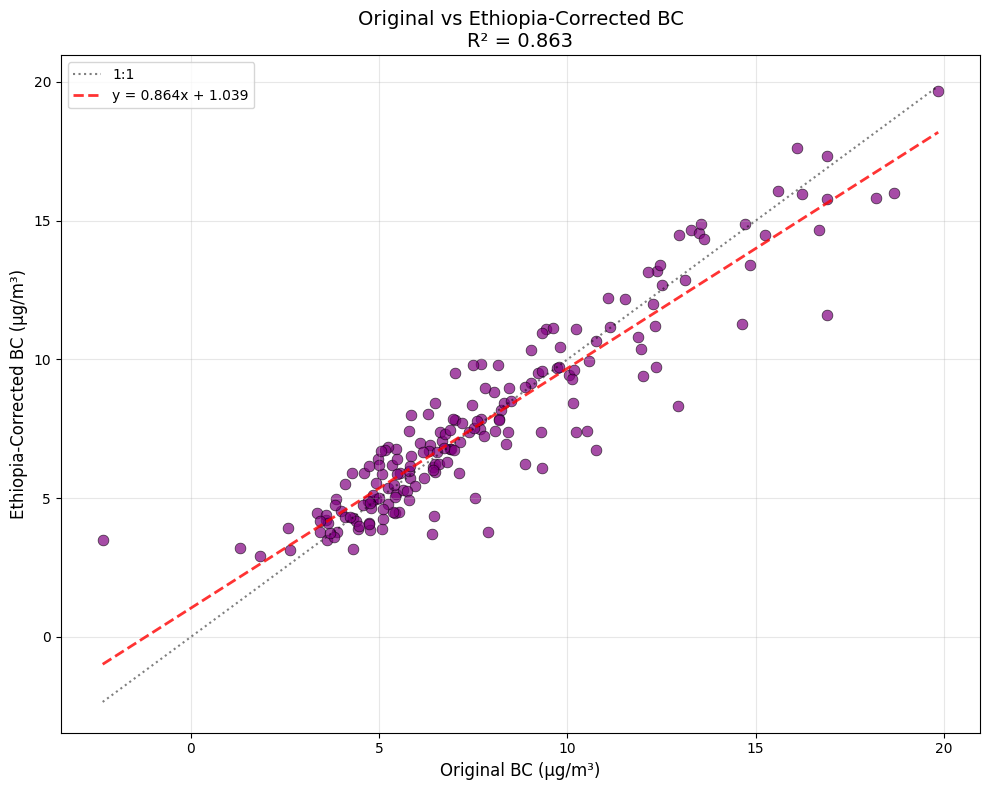

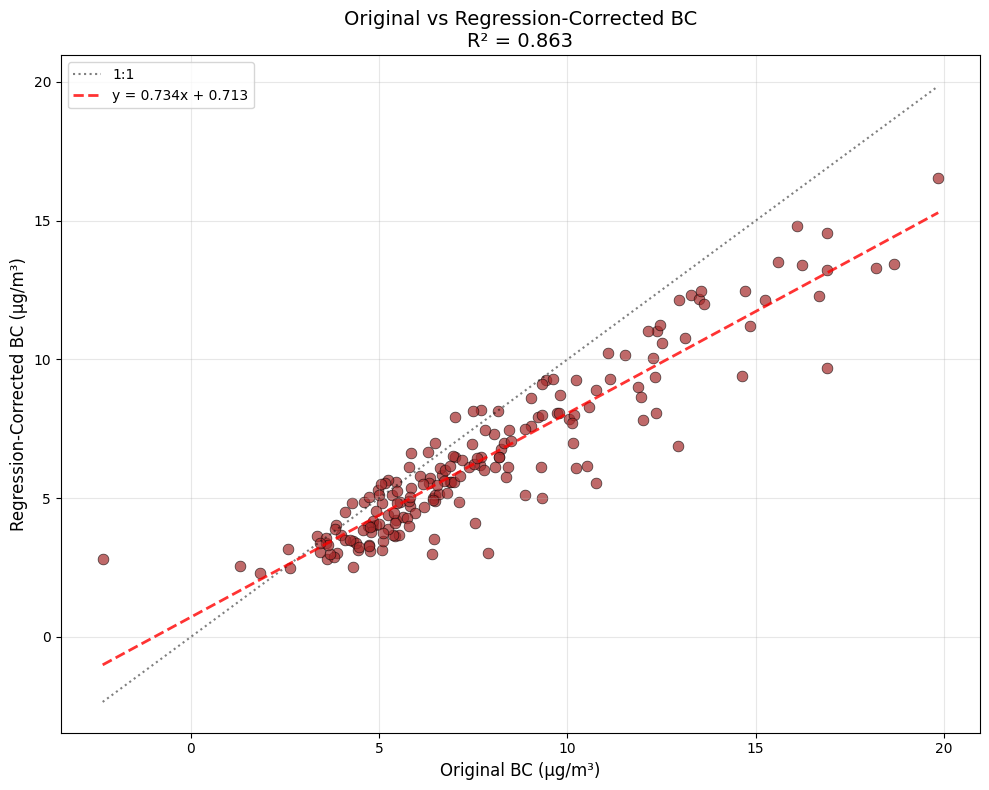

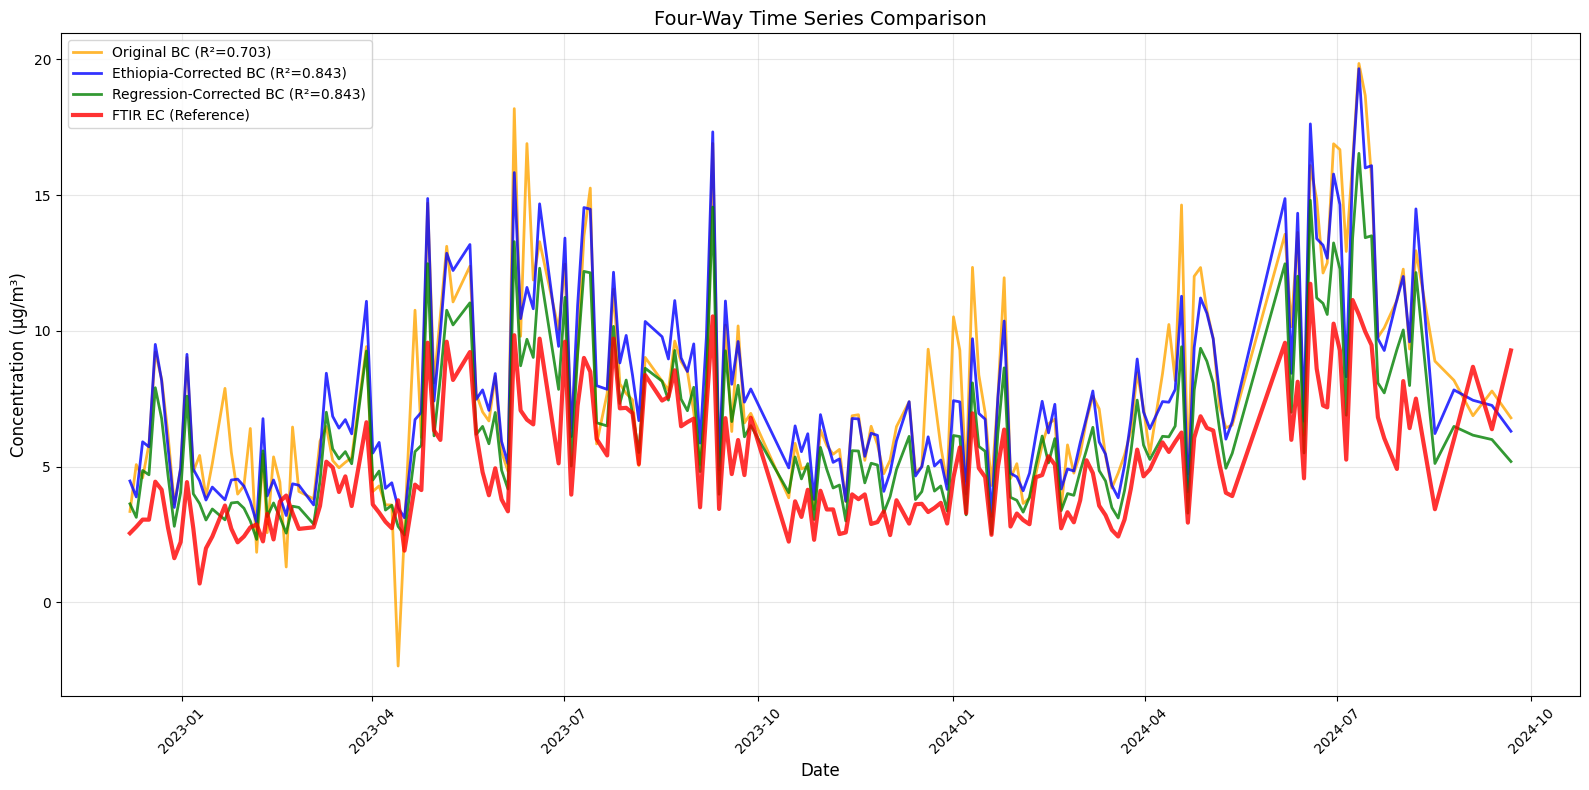

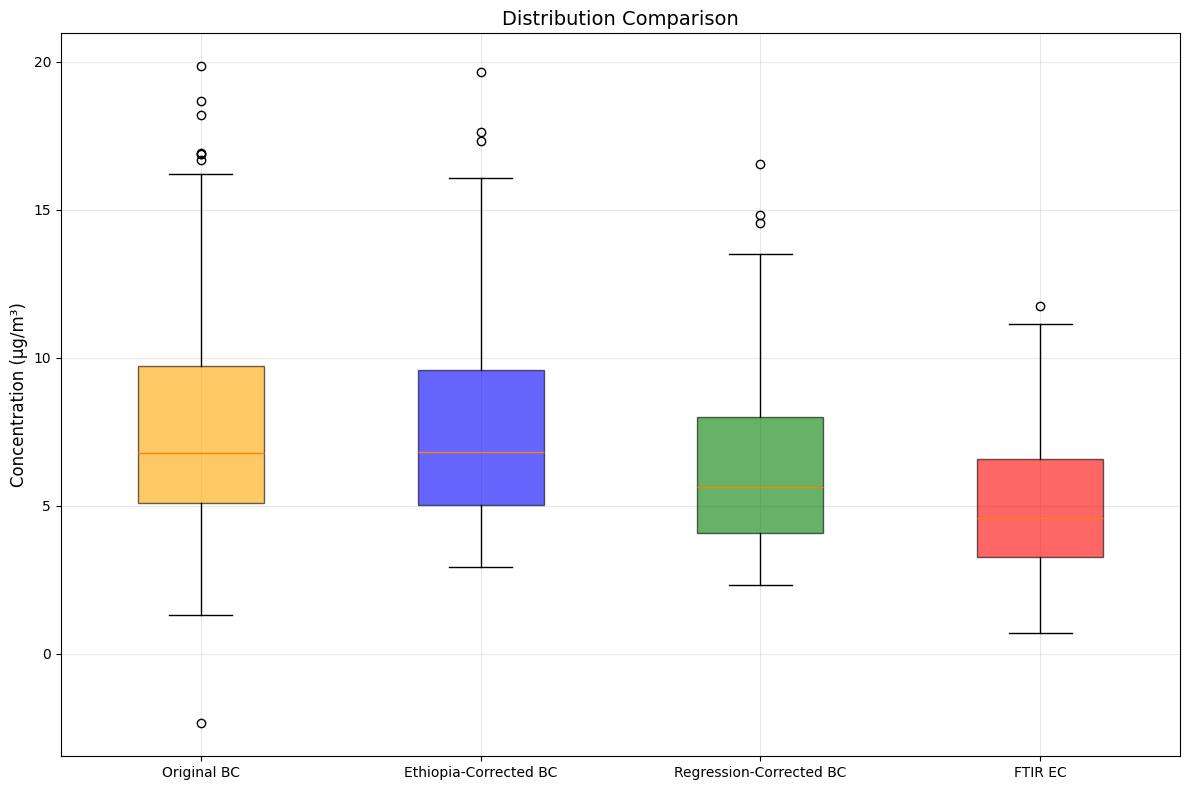

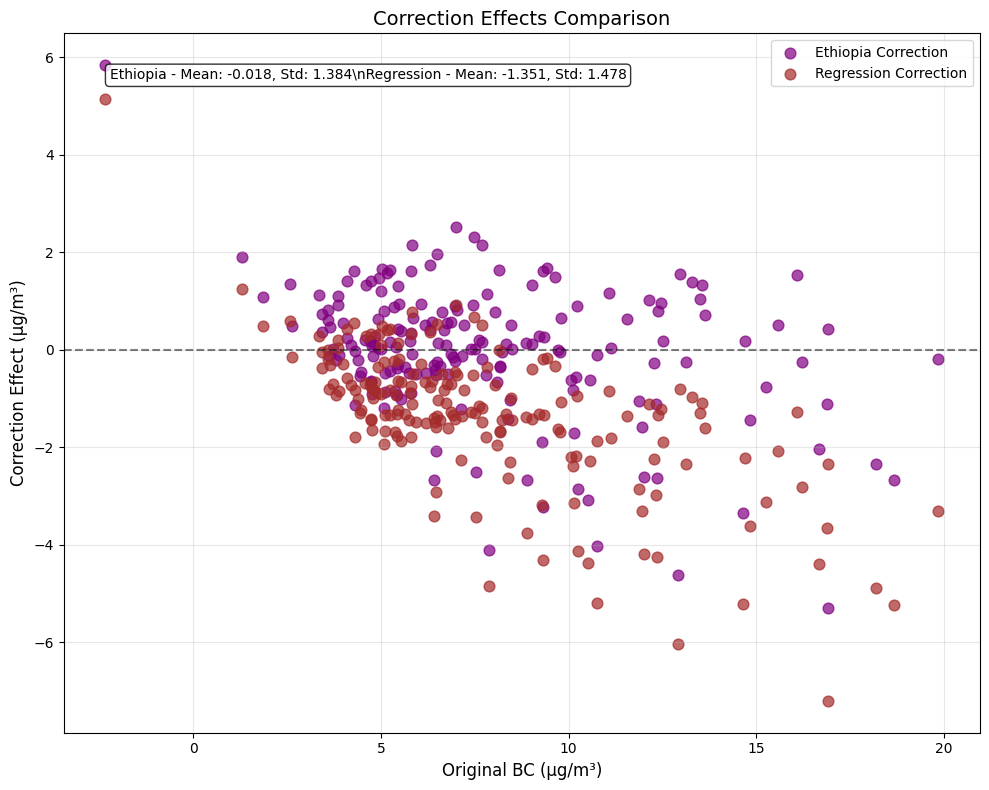

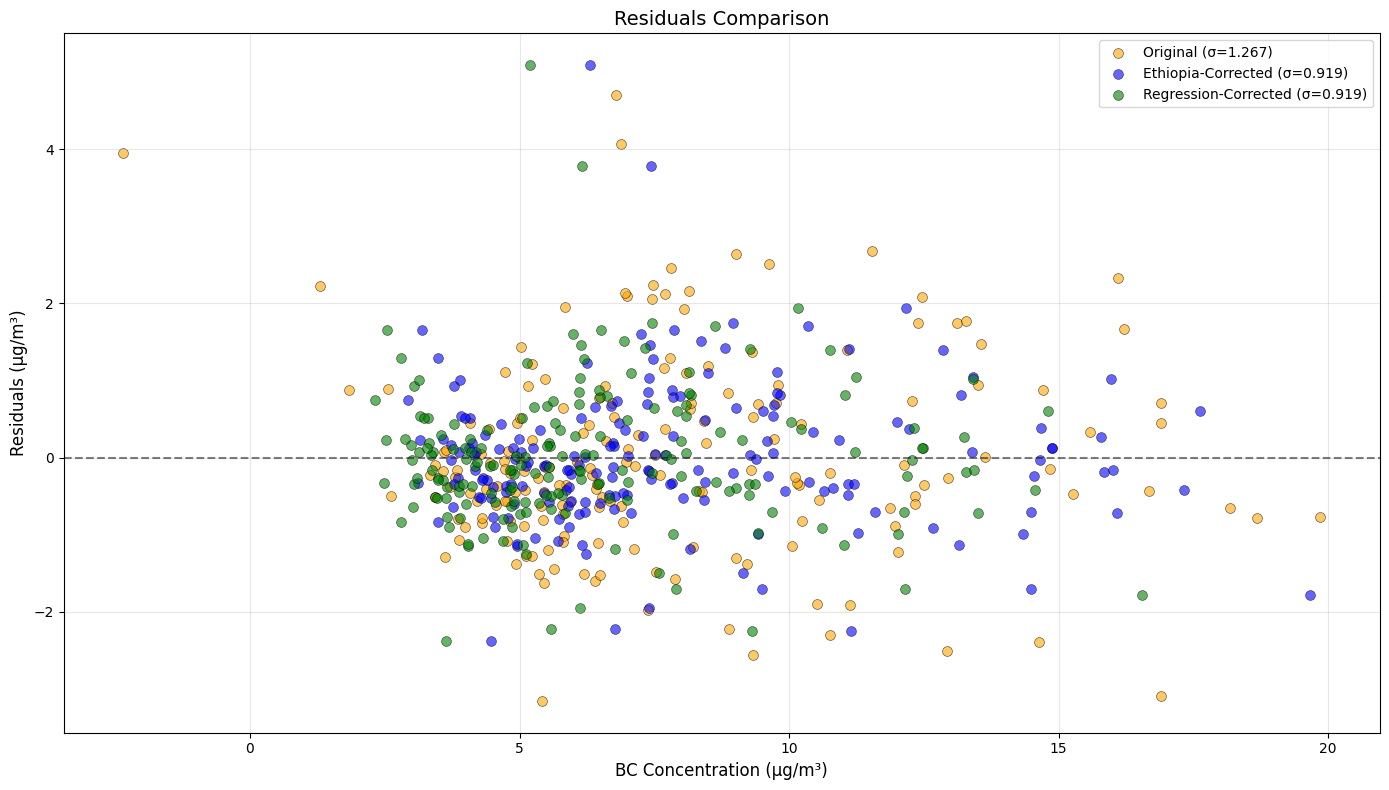


🎯 COMPREHENSIVE FOUR-WAY ANALYSIS RESULTS:
🏢 Site: ETAD
📊 Data Points: 184
📅 Date Range: 2022-12-07 to 2024-09-21

📊 CORRELATION PERFORMANCE RANKING:
  🥇 Ethiopia-Corrected BC:
     R² = 0.843, Slope = 0.613, Intercept = 0.324
  🥈 Regression-Corrected BC:
     R² = 0.843, Slope = 0.721, Intercept = 0.447
  🥉 Original BC:
     R² = 0.703, Slope = 0.520, Intercept = 1.034

📈 IMPROVEMENT ANALYSIS:
  ✅ Ethiopia vs Original: +0.141 R² improvement (20.0%)
  ✅ Regression vs Original: +0.141 R² improvement (20.0%)
  ⚠️ Regression vs Ethiopia: -0.000 R² degradation (0.0%)

📐 BIAS ASSESSMENT (deviation from 1:1 line):
  🎯 Ethiopia-Corrected BC: 0.711
  📊 Regression-Corrected BC: 0.726
  ⚠️ Original BC: 1.513

🏆 FINAL RECOMMENDATIONS:
  ✅ CLEAR WINNER: Ethiopia-Corrected BC
     - Best correlation with FTIR (R² = 0.843)
     - Lowest bias from 1:1 line (0.711)
  👍 Ethiopia corrections outperform original data
  ⚖️ Ethiopia and regression corrections perform similarly
     - Choose based on physi

In [29]:
# %%
# FOUR-WAY COMPARISON: Corrected BC, Original BC, FTIR EC, and Regression-Corrected BC
print("🎯 FOUR-WAY COMPARISON: Corrected BC vs Original BC vs FTIR EC vs Regression-Corrected BC")

if 'merged_data' in locals() and len(merged_data) > 0:
    # Find all BC columns
    all_cols = list(merged_data.columns)
    bc_original_cols = [col for col in all_cols if 'BCc' in col and 
                       'corrected' not in col and 'manual' not in col and 'optimized' not in col]
    bc_corrected_cols = [col for col in all_cols if 'BCc' in col and 'corrected' in col]
    
    # Find FTIR EC column
    ftir_cols = [col for col in all_cols if any(x in col.lower() for x in ['ec', 'oc', 'ftir'])]
    ec_col = None
    ec_candidates = ['EC_ftir', 'EC', 'Elemental Carbon']
    for candidate in ec_candidates:
        matching_cols = [col for col in ftir_cols if candidate in col]
        if matching_cols:
            ec_col = matching_cols[0]
            break
    if ec_col is None and ftir_cols:
        ec_col = ftir_cols[0]
    
    # Check for regression-corrected BC column
    regression_corrected_col = 'BC_regression_corrected_ug'
    
    # Select BC columns (prefer IR wavelength)
    bc_original_col = None
    bc_corrected_col = None
    
    wavelength_priority = ['IR', 'Red', 'Blue', 'Green', 'UV']
    
    # Find original BC column
    if bc_original_cols:
        for wl in wavelength_priority:
            matching = [col for col in bc_original_cols if wl in col and 'smoothed' not in col and 'denominator' not in col]
            if matching:
                bc_original_col = matching[0]
                break
        if bc_original_col is None:
            bc_original_col = bc_original_cols[0]
    
    # Find corrected BC column
    if bc_corrected_cols:
        for wl in wavelength_priority:
            matching = [col for col in bc_corrected_cols if wl in col]
            if matching:
                bc_corrected_col = matching[0]
                break
        if bc_corrected_col is None:
            bc_corrected_col = bc_corrected_cols[0]
    
    print(f"📊 Using original BC column: {bc_original_col}")
    print(f"✅ Using corrected BC column: {bc_corrected_col}")
    print(f"🧪 Using FTIR column: {ec_col}")
    print(f"📈 Using regression-corrected BC column: {regression_corrected_col}")
    
    # Check if all required columns exist
    required_cols = [bc_original_col, bc_corrected_col, ec_col]
    optional_cols = [regression_corrected_col]
    
    available_cols = [col for col in required_cols if col and col in merged_data.columns]
    has_regression = regression_corrected_col in merged_data.columns
    
    print(f"🔍 Available columns: {len(available_cols)}/3 required + {'1' if has_regression else '0'}/1 optional")
    
    if len(available_cols) >= 3:
        # Get overlapping data for all datasets
        bc_orig_data = merged_data[bc_original_col].dropna()
        bc_corr_data = merged_data[bc_corrected_col].dropna()
        ec_data = merged_data[ec_col].dropna()
        
        # Find common indices across the three main datasets
        common_idx = bc_orig_data.index.intersection(bc_corr_data.index).intersection(ec_data.index)
        
        # Add regression-corrected data if available
        if has_regression:
            bc_regr_data = merged_data[regression_corrected_col].dropna()
            common_idx = common_idx.intersection(bc_regr_data.index)
            print(f"\n📊 Data Coverage (Four-Way):")
        else:
            print(f"\n📊 Data Coverage (Three-Way - no regression correction available):")
        
        print(f"  📈 Original BC data points: {len(bc_orig_data)}")
        print(f"  ✅ Corrected BC data points: {len(bc_corr_data)}")
        print(f"  🧪 FTIR data points: {len(ec_data)}")
        if has_regression:
            print(f"  📈 Regression-corrected BC data points: {len(bc_regr_data)}")
            print(f"  🔗 Four-way overlapping points: {len(common_idx)}")
        else:
            print(f"  🔗 Three-way overlapping points: {len(common_idx)}")
        
        if len(common_idx) > 3:
            # Convert all to µg/m³
            bc_orig_ug = bc_orig_data.loc[common_idx] / 1000    # ng/m³ → µg/m³
            bc_corr_ug = bc_corr_data.loc[common_idx] / 1000    # ng/m³ → µg/m³
            ec_ftir = ec_data.loc[common_idx]                   # Already in µg/m³
            
            if has_regression:
                bc_regr_ug = bc_regr_data.loc[common_idx]       # Already in µg/m³
            
            print(f"\n🔄 Unit Conversions:")
            print(f"  📈 Original BC: {bc_orig_data.loc[common_idx].median():.0f} ng/m³ → {bc_orig_ug.median():.2f} µg/m³")
            print(f"  ✅ Corrected BC: {bc_corr_data.loc[common_idx].median():.0f} ng/m³ → {bc_corr_ug.median():.2f} µg/m³")
            print(f"  🧪 FTIR EC: {ec_ftir.median():.2f} µg/m³")
            if has_regression:
                print(f"  📈 Regression-corrected BC: {bc_regr_ug.median():.2f} µg/m³")
            
            # Calculate correlations and regressions
            from scipy import stats
            
            # Original BC vs FTIR
            slope_orig, intercept_orig, r_orig, p_orig, _ = stats.linregress(bc_orig_ug, ec_ftir)
            
            # Corrected BC vs FTIR
            slope_corr, intercept_corr, r_corr, p_corr, _ = stats.linregress(bc_corr_ug, ec_ftir)
            
            # Original vs Corrected BC
            slope_bc_comp, intercept_bc_comp, r_bc_comp, p_bc_comp, _ = stats.linregress(bc_orig_ug, bc_corr_ug)
            
            # Regression-corrected BC vs FTIR (if available)
            if has_regression:
                slope_regr, intercept_regr, r_regr, p_regr, _ = stats.linregress(bc_regr_ug, ec_ftir)
                # Original vs Regression-corrected
                slope_regr_comp, intercept_regr_comp, r_regr_comp, p_regr_comp, _ = stats.linregress(bc_orig_ug, bc_regr_ug)
            
            print(f"\n📊 CORRELATION ANALYSIS:")
            print(f"  🔧 Original BC vs FTIR:     R² = {r_orig**2:.3f}, Slope = {slope_orig:.3f}")
            print(f"  ✅ Corrected BC vs FTIR:    R² = {r_corr**2:.3f}, Slope = {slope_corr:.3f}")
            if has_regression:
                print(f"  📈 Regression BC vs FTIR:   R² = {r_regr**2:.3f}, Slope = {slope_regr:.3f}")
            print(f"  🔄 Original vs Corrected:   R² = {r_bc_comp**2:.3f}, Slope = {slope_bc_comp:.3f}")
            if has_regression:
                print(f"  🔄 Original vs Regression:  R² = {r_regr_comp**2:.3f}, Slope = {slope_regr_comp:.3f}")
            
            # Graph 1: Original BC vs FTIR
            fig1, ax1 = plt.subplots(figsize=(10, 8))
            ax1.scatter(bc_orig_ug, ec_ftir, alpha=0.7, color='orange', s=60, edgecolor='black', linewidth=0.5)
            ax1.plot([bc_orig_ug.min(), bc_orig_ug.max()], 
                    [bc_orig_ug.min(), bc_orig_ug.max()], 'k:', alpha=0.5, label='1:1')
            line_x = np.linspace(bc_orig_ug.min(), bc_orig_ug.max(), 100)
            line_y = slope_orig * line_x + intercept_orig
            ax1.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2, 
                    label=f'y = {slope_orig:.3f}x + {intercept_orig:.3f}')
            ax1.set_xlabel('Original BC (µg/m³)', fontsize=12)
            ax1.set_ylabel('FTIR EC (µg/m³)', fontsize=12)
            ax1.set_title(f'Original BC vs FTIR EC\nR² = {r_orig**2:.3f}', fontsize=14)
            ax1.grid(True, alpha=0.3)
            ax1.legend()
            plt.tight_layout()
            plt.show()
            
            # Graph 2: Corrected BC vs FTIR
            fig2, ax2 = plt.subplots(figsize=(10, 8))
            ax2.scatter(bc_corr_ug, ec_ftir, alpha=0.7, color='blue', s=60, edgecolor='black', linewidth=0.5)
            ax2.plot([bc_corr_ug.min(), bc_corr_ug.max()], 
                    [bc_corr_ug.min(), bc_corr_ug.max()], 'k:', alpha=0.5, label='1:1')
            line_x = np.linspace(bc_corr_ug.min(), bc_corr_ug.max(), 100)
            line_y = slope_corr * line_x + intercept_corr
            ax2.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2,
                    label=f'y = {slope_corr:.3f}x + {intercept_corr:.3f}')
            ax2.set_xlabel('Ethiopia-Corrected BC (µg/m³)', fontsize=12)
            ax2.set_ylabel('FTIR EC (µg/m³)', fontsize=12)
            ax2.set_title(f'Ethiopia-Corrected BC vs FTIR EC\nR² = {r_corr**2:.3f}', fontsize=14)
            ax2.grid(True, alpha=0.3)
            ax2.legend()
            plt.tight_layout()
            plt.show()
            
            # Graph 3: Regression-corrected BC vs FTIR (if available)
            if has_regression:
                fig3, ax3 = plt.subplots(figsize=(10, 8))
                ax3.scatter(bc_regr_ug, ec_ftir, alpha=0.7, color='green', s=60, edgecolor='black', linewidth=0.5)
                ax3.plot([bc_regr_ug.min(), bc_regr_ug.max()], 
                        [bc_regr_ug.min(), bc_regr_ug.max()], 'k:', alpha=0.5, label='1:1')
                line_x = np.linspace(bc_regr_ug.min(), bc_regr_ug.max(), 100)
                line_y = slope_regr * line_x + intercept_regr
                ax3.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2,
                        label=f'y = {slope_regr:.3f}x + {intercept_regr:.3f}')
                ax3.set_xlabel('Regression-Corrected BC (µg/m³)', fontsize=12)
                ax3.set_ylabel('FTIR EC (µg/m³)', fontsize=12)
                ax3.set_title(f'Regression-Corrected BC vs FTIR EC\nR² = {r_regr**2:.3f}', fontsize=14)
                ax3.grid(True, alpha=0.3)
                ax3.legend()
                plt.tight_layout()
                plt.show()
            
            # Graph 4: Original vs Corrected BC
            fig4, ax4 = plt.subplots(figsize=(10, 8))
            ax4.scatter(bc_orig_ug, bc_corr_ug, alpha=0.7, color='purple', s=60, edgecolor='black', linewidth=0.5)
            ax4.plot([bc_orig_ug.min(), bc_orig_ug.max()], 
                    [bc_orig_ug.min(), bc_orig_ug.max()], 'k:', alpha=0.5, label='1:1')
            line_x = np.linspace(bc_orig_ug.min(), bc_orig_ug.max(), 100)
            line_y = slope_bc_comp * line_x + intercept_bc_comp
            ax4.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2,
                    label=f'y = {slope_bc_comp:.3f}x + {intercept_bc_comp:.3f}')
            ax4.set_xlabel('Original BC (µg/m³)', fontsize=12)
            ax4.set_ylabel('Ethiopia-Corrected BC (µg/m³)', fontsize=12)
            ax4.set_title(f'Original vs Ethiopia-Corrected BC\nR² = {r_bc_comp**2:.3f}', fontsize=14)
            ax4.grid(True, alpha=0.3)
            ax4.legend()
            plt.tight_layout()
            plt.show()
            
            # Graph 5: Original vs Regression-corrected BC (if available)
            if has_regression:
                fig5, ax5 = plt.subplots(figsize=(10, 8))
                ax5.scatter(bc_orig_ug, bc_regr_ug, alpha=0.7, color='brown', s=60, edgecolor='black', linewidth=0.5)
                ax5.plot([bc_orig_ug.min(), bc_orig_ug.max()], 
                        [bc_orig_ug.min(), bc_orig_ug.max()], 'k:', alpha=0.5, label='1:1')
                line_x = np.linspace(bc_orig_ug.min(), bc_orig_ug.max(), 100)
                line_y = slope_regr_comp * line_x + intercept_regr_comp
                ax5.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2,
                        label=f'y = {slope_regr_comp:.3f}x + {intercept_regr_comp:.3f}')
                ax5.set_xlabel('Original BC (µg/m³)', fontsize=12)
                ax5.set_ylabel('Regression-Corrected BC (µg/m³)', fontsize=12)
                ax5.set_title(f'Original vs Regression-Corrected BC\nR² = {r_regr_comp**2:.3f}', fontsize=14)
                ax5.grid(True, alpha=0.3)
                ax5.legend()
                plt.tight_layout()
                plt.show()
            
            # Graph 6: Time series comparison - all datasets
            fig6, ax6 = plt.subplots(figsize=(16, 8))
            ax6.plot(bc_orig_ug.index, bc_orig_ug.values, 'orange', 
                    label=f'Original BC (R²={r_orig**2:.3f})', alpha=0.8, linewidth=2)
            ax6.plot(bc_corr_ug.index, bc_corr_ug.values, 'blue', 
                    label=f'Ethiopia-Corrected BC (R²={r_corr**2:.3f})', alpha=0.8, linewidth=2)
            if has_regression:
                ax6.plot(bc_regr_ug.index, bc_regr_ug.values, 'green', 
                        label=f'Regression-Corrected BC (R²={r_regr**2:.3f})', alpha=0.8, linewidth=2)
            ax6.plot(ec_ftir.index, ec_ftir.values, 'red', 
                    label='FTIR EC (Reference)', alpha=0.8, linewidth=3)
            ax6.set_xlabel('Date', fontsize=12)
            ax6.set_ylabel('Concentration (µg/m³)', fontsize=12)
            title = 'Four-Way Time Series Comparison' if has_regression else 'Three-Way Time Series Comparison'
            ax6.set_title(title, fontsize=14)
            ax6.legend()
            ax6.grid(True, alpha=0.3)
            ax6.tick_params(axis='x', rotation=45)
            plt.tight_layout()
            plt.show()
            
            # Graph 7: Box plot comparison
            fig7, ax7 = plt.subplots(figsize=(12, 8))
            if has_regression:
                data_for_box = [bc_orig_ug.values, bc_corr_ug.values, bc_regr_ug.values, ec_ftir.values]
                labels_for_box = ['Original BC', 'Ethiopia-Corrected BC', 'Regression-Corrected BC', 'FTIR EC']
                colors = ['orange', 'blue', 'green', 'red']
            else:
                data_for_box = [bc_orig_ug.values, bc_corr_ug.values, ec_ftir.values]
                labels_for_box = ['Original BC', 'Ethiopia-Corrected BC', 'FTIR EC']
                colors = ['orange', 'blue', 'red']
            
            bp = ax7.boxplot(data_for_box, labels=labels_for_box, patch_artist=True)
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
            ax7.set_ylabel('Concentration (µg/m³)', fontsize=12)
            ax7.set_title('Distribution Comparison', fontsize=14)
            ax7.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Graph 8: Ethiopia correction effect
            fig8, ax8 = plt.subplots(figsize=(10, 8))
            ethiopia_correction = bc_corr_ug - bc_orig_ug
            ax8.scatter(bc_orig_ug, ethiopia_correction, alpha=0.7, color='purple', s=60, label='Ethiopia Correction')
            if has_regression:
                regression_correction = bc_regr_ug - bc_orig_ug
                ax8.scatter(bc_orig_ug, regression_correction, alpha=0.7, color='brown', s=60, label='Regression Correction')
            ax8.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax8.set_xlabel('Original BC (µg/m³)', fontsize=12)
            ax8.set_ylabel('Correction Effect (µg/m³)', fontsize=12)
            ax8.set_title('Correction Effects Comparison', fontsize=14)
            ax8.grid(True, alpha=0.3)
            ax8.legend()
            
            # Statistics text
            eth_mean = ethiopia_correction.mean()
            eth_std = ethiopia_correction.std()
            stats_text = f'Ethiopia - Mean: {eth_mean:.3f}, Std: {eth_std:.3f}'
            if has_regression:
                regr_mean = regression_correction.mean()
                regr_std = regression_correction.std()
                stats_text += f'\\nRegression - Mean: {regr_mean:.3f}, Std: {regr_std:.3f}'
            
            ax8.text(0.05, 0.95, stats_text, 
                    transform=ax8.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    verticalalignment='top', fontsize=10)
            plt.tight_layout()
            plt.show()
            
            # Graph 9: Residuals comparison
            fig9, ax9 = plt.subplots(figsize=(14, 8))
            residuals_orig = ec_ftir - (slope_orig * bc_orig_ug + intercept_orig)
            residuals_corr = ec_ftir - (slope_corr * bc_corr_ug + intercept_corr)
            
            ax9.scatter(bc_orig_ug, residuals_orig, alpha=0.6, color='orange', s=50, 
                       label=f'Original (σ={residuals_orig.std():.3f})', edgecolor='black', linewidth=0.5)
            ax9.scatter(bc_corr_ug, residuals_corr, alpha=0.6, color='blue', s=50, 
                       label=f'Ethiopia-Corrected (σ={residuals_corr.std():.3f})', edgecolor='black', linewidth=0.5)
            
            if has_regression:
                residuals_regr = ec_ftir - (slope_regr * bc_regr_ug + intercept_regr)
                ax9.scatter(bc_regr_ug, residuals_regr, alpha=0.6, color='green', s=50, 
                           label=f'Regression-Corrected (σ={residuals_regr.std():.3f})', edgecolor='black', linewidth=0.5)
            
            ax9.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax9.set_xlabel('BC Concentration (µg/m³)', fontsize=12)
            ax9.set_ylabel('Residuals (µg/m³)', fontsize=12)
            ax9.set_title('Residuals Comparison', fontsize=14)
            ax9.legend()
            ax9.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # COMPREHENSIVE ANALYSIS SUMMARY
            print(f"\n🎯 COMPREHENSIVE FOUR-WAY ANALYSIS RESULTS:")
            print(f"=" * 70)
            print(f"🏢 Site: {SITE_CODE}")
            print(f"📊 Data Points: {len(common_idx)}")
            print(f"📅 Date Range: {common_idx.min().date()} to {common_idx.max().date()}")
            
            print(f"\n📊 CORRELATION PERFORMANCE RANKING:")
            # Create performance ranking
            performance_data = [
                ('Original BC', r_orig**2, slope_orig, intercept_orig),
                ('Ethiopia-Corrected BC', r_corr**2, slope_corr, intercept_corr)
            ]
            if has_regression:
                performance_data.append(('Regression-Corrected BC', r_regr**2, slope_regr, intercept_regr))
            
            # Sort by R²
            performance_data.sort(key=lambda x: x[1], reverse=True)
            
            for i, (method, r2, slope, intercept) in enumerate(performance_data, 1):
                rank_emoji = ['🥇', '🥈', '🥉', '4️⃣'][i-1]
                print(f"  {rank_emoji} {method}:")
                print(f"     R² = {r2:.3f}, Slope = {slope:.3f}, Intercept = {intercept:.3f}")
            
            # Calculate improvements/changes
            print(f"\n📈 IMPROVEMENT ANALYSIS:")
            r2_improvements = {
                'Ethiopia vs Original': r_corr**2 - r_orig**2,
            }
            if has_regression:
                r2_improvements['Regression vs Original'] = r_regr**2 - r_orig**2
                r2_improvements['Regression vs Ethiopia'] = r_regr**2 - r_corr**2
            
            for comparison, improvement in r2_improvements.items():
                if improvement > 0:
                    print(f"  ✅ {comparison}: +{improvement:.3f} R² improvement ({improvement/r_orig**2*100:.1f}%)")
                elif improvement < 0:
                    print(f"  ⚠️ {comparison}: {improvement:.3f} R² degradation ({abs(improvement)/r_orig**2*100:.1f}%)")
                else:
                    print(f"  ⚖️ {comparison}: No change in R²")
            
            # Bias assessment
            print(f"\n📐 BIAS ASSESSMENT (deviation from 1:1 line):")
            bias_data = [
                ('Original BC', abs(slope_orig - 1.0) + abs(intercept_orig)),
                ('Ethiopia-Corrected BC', abs(slope_corr - 1.0) + abs(intercept_corr))
            ]
            if has_regression:
                bias_data.append(('Regression-Corrected BC', abs(slope_regr - 1.0) + abs(intercept_regr)))
            
            bias_data.sort(key=lambda x: x[1])  # Sort by bias (lower is better)
            
            for i, (method, bias) in enumerate(bias_data, 1):
                rank_emoji = ['🎯', '📊', '⚠️', '❌'][i-1]
                print(f"  {rank_emoji} {method}: {bias:.3f}")
            
            print(f"\n🏆 FINAL RECOMMENDATIONS:")
            
            # Find best performing method
            best_r2_method = performance_data[0][0]
            best_bias_method = bias_data[0][0]
            
            if best_r2_method == best_bias_method:
                print(f"  ✅ CLEAR WINNER: {best_r2_method}")
                print(f"     - Best correlation with FTIR (R² = {performance_data[0][1]:.3f})")
                print(f"     - Lowest bias from 1:1 line ({bias_data[0][1]:.3f})")
            else:
                print(f"  📊 MIXED RESULTS:")
                print(f"     - Best correlation: {best_r2_method} (R² = {performance_data[0][1]:.3f})")
                print(f"     - Lowest bias: {best_bias_method} (bias = {bias_data[0][1]:.3f})")
                print(f"     - Consider research objectives when choosing")
            
            # Specific method recommendations
            if has_regression:
                if r_regr**2 > max(r_orig**2, r_corr**2):
                    print(f"  🎉 Regression correction shows best FTIR agreement!")
                elif r_corr**2 > r_orig**2:
                    print(f"  👍 Ethiopia corrections outperform original data")
                
                # Compare correction approaches
                if abs(r_regr**2 - r_corr**2) < 0.01:
                    print(f"  ⚖️ Ethiopia and regression corrections perform similarly")
                    print(f"     - Choose based on physical interpretability vs. empirical fit")
                
        else:
            comparison_type = "four-way" if has_regression else "three-way"
            print(f"⚠️ Insufficient {comparison_type} overlapping data ({len(common_idx)} points)")
            
    else:
        print(f"❌ Cannot proceed with comparison:")
        missing_cols = []
        if not bc_original_col or bc_original_col not in merged_data.columns:
            missing_cols.append(f"Original BC: {bc_original_col}")
        if not bc_corrected_col or bc_corrected_col not in merged_data.columns:
            missing_cols.append(f"Corrected BC: {bc_corrected_col}")
        if not ec_col or ec_col not in merged_data.columns:
            missing_cols.append(f"FTIR EC: {ec_col}")
        
        for missing in missing_cols:
            print(f"  ❌ {missing}")
        
        if not has_regression:
            print(f"  ℹ️ Regression-corrected BC not available (run regression correction cell first)")
            
else:
    print("❌ No merged data available for four-way comparison")